In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib import cm
import numpy as np
import random
import json
from IPython.display import clear_output
import os

from result_plots.ProfilingBased.common.common import read_data, get_metric_mapping
from result_plots.ProfilingBased.common.process_data_from_solver import get_mean_from_iterations, normalize_error_result, get_ensemble_error
from result_plots.ProfilingBased.common.plot import get_result_from_pkl, get_x_position, get_xtick_position, \
                                                plot_raw, get_gain, gain_over_strawman, consolidate_gain_over_strawman

from result_plots.ProfilingBased.common.heatmap import plot_heatmap

## plotting function

In [2]:
def call_plotting(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name = "Test", \
                  mem_size = 131072, all_metrics = ['hh', 'change_det', 'entropy', 'card', 'fsd'], isSaveFig = False):
    plot_raw(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name, all_metrics, isSaveFig)
    gain_result = gain_over_strawman(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name, all_metrics, isSaveFig)
    merge_gain_result = consolidate_gain_over_strawman(gain_result, name, all_metrics, isSaveFig)
    
    global global_merge_gain_all_mem
    for d in merge_gain_result:
        global_merge_gain_all_mem.append(d)

    global global_name_all_mem
    global_name_all_mem.append(name)
    

### set boxplot

In [3]:
## Plot raw result
def boxplot_impact_distribution(data, labels, name, isSaveFig = False):
    ## comparison version plot
    # box plot 
    # https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
    # Box plots with custom fill colors
    # https://matplotlib.org/stable/gallery/statistics/boxplot_color.html
    big_fontsize = 32
    small_fontsize = 28
    x_axis_cnt = 5

    import matplotlib.patches as mpatches

    xlabels = labels
    colors = ['deeppink', 'darkred', 'royalblue', 'darkblue', 'darkgreen']
    colors = colors * int(len(data) / x_axis_cnt) # 5 distribution

    fig = plt.figure(figsize = (8, 6))
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])
    
    ax.set_ylim([0, 100])

    # Creating plot
    bplot = ax.boxplot(x=data, 
                       positions = get_x_position(int(len(data) / x_axis_cnt), x_axis_cnt),
                       patch_artist=True) # , showfliers=False
    
    # ax.set_xlim(0, 1)

    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    # plt.axhline(y = 0, color = 'r', linestyle = '--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.grid()
    
    plt.ylabel("Error reduction (%)", fontsize=big_fontsize)
    plt.xlabel("Testing sets", fontsize=big_fontsize)
    plt.xticks(np.array(get_xtick_position(int(len(data) / x_axis_cnt), x_axis_cnt)) - 0.5
               , xlabels, fontsize=small_fontsize)
    plt.yticks(fontsize=small_fontsize)

    # plt.title(f"Impact of # of flows - {name}", fontsize=18)

    # create legends
    legend_labels = []
    legend_patch = []
    for i in range(len(labels)):
        legend_labels.append(f'{labels[i]} profiles')
        legend_patch.append(mpatches.Patch(color=colors[i], label=legend_labels[i]))

    plt.legend(handles=legend_patch, fontsize=small_fontsize, frameon=False, ncol=2) # , loc="upper right"

    # import pickle
    # with open(f'pickles/{name}.pkl', 'wb') as fout:
    #     pickle.dump(fig, fout)
    global output_dir
    filename = name.split(' ')[0]
    if isSaveFig:
        if not os.path.exists(f'{output_dir}/boxplot/'):
            os.makedirs(f'{output_dir}/boxplot/')
        plt.savefig(f'{output_dir}/boxplot/number_of_flow_ensemble_{filename}.pdf', format='pdf', bbox_inches='tight')

    # show plot
    plt.show()

## Configs

### Set training set config

In [4]:
# # zipf 1.1 0.1x
datasets_1 = ['20180517-130900-zipf-1.1-numberofFlow-0.1x-srcIP.pcap/', '20180517-131000-zipf-1.1-numberofFlow-0.1x-srcIP.pcap/','20180517-131100-zipf-1.1-numberofFlow-0.1x-srcIP.pcap/',
            '20180621-130900-zipf-1.1-numberofFlow-0.1x-srcIP.pcap/', '20180621-131000-zipf-1.1-numberofFlow-0.1x-srcIP.pcap/','20180621-131100-zipf-1.1-numberofFlow-0.1x-srcIP.pcap/', 
            '20180816-130900-zipf-1.1-numberofFlow-0.1x-srcIP.pcap/', '20180816-131000-zipf-1.1-numberofFlow-0.1x-srcIP.pcap/','20180816-131100-zipf-1.1-numberofFlow-0.1x-srcIP.pcap/', ]

# # zipf 1.1 0.5x
datasets_2 = ['20180517-130900-zipf-1.1-numberofFlow-0.5x-srcIP.pcap/', '20180517-131000-zipf-1.1-numberofFlow-0.5x-srcIP.pcap/','20180517-131100-zipf-1.1-numberofFlow-0.5x-srcIP.pcap/',
            '20180621-130900-zipf-1.1-numberofFlow-0.5x-srcIP.pcap/', '20180621-131000-zipf-1.1-numberofFlow-0.5x-srcIP.pcap/','20180621-131100-zipf-1.1-numberofFlow-0.5x-srcIP.pcap/', 
            '20180816-130900-zipf-1.1-numberofFlow-0.5x-srcIP.pcap/', '20180816-131000-zipf-1.1-numberofFlow-0.5x-srcIP.pcap/','20180816-131100-zipf-1.1-numberofFlow-0.5x-srcIP.pcap/', ]

# # zipf 1.1 1x
datasets_3 = ['20180517-130900-zipf-1.1-numberofFlow-1x-srcIP.pcap/', '20180517-131000-zipf-1.1-numberofFlow-1x-srcIP.pcap/','20180517-131100-zipf-1.1-numberofFlow-1x-srcIP.pcap/',
            '20180621-130900-zipf-1.1-numberofFlow-1x-srcIP.pcap/', '20180621-131000-zipf-1.1-numberofFlow-1x-srcIP.pcap/','20180621-131100-zipf-1.1-numberofFlow-1x-srcIP.pcap/', 
            '20180816-130900-zipf-1.1-numberofFlow-1x-srcIP.pcap/', '20180816-131000-zipf-1.1-numberofFlow-1x-srcIP.pcap/','20180816-131100-zipf-1.1-numberofFlow-1x-srcIP.pcap/', ]

# # zipf 1.1 2x
datasets_4 = ['20180517-130900-zipf-1.1-numberofFlow-2x-srcIP.pcap/', '20180517-131000-zipf-1.1-numberofFlow-2x-srcIP.pcap/','20180517-131100-zipf-1.1-numberofFlow-2x-srcIP.pcap/',
            '20180621-130900-zipf-1.1-numberofFlow-2x-srcIP.pcap/', '20180621-131000-zipf-1.1-numberofFlow-2x-srcIP.pcap/','20180621-131100-zipf-1.1-numberofFlow-2x-srcIP.pcap/', 
            '20180816-130900-zipf-1.1-numberofFlow-2x-srcIP.pcap/', '20180816-131000-zipf-1.1-numberofFlow-2x-srcIP.pcap/','20180816-131100-zipf-1.1-numberofFlow-2x-srcIP.pcap/', ]

# # zipf 1.1 4x
datasets_5 = ['20180517-130900-zipf-1.1-numberofFlow-4x-srcIP.pcap/', '20180517-131000-zipf-1.1-numberofFlow-4x-srcIP.pcap/','20180517-131100-zipf-1.1-numberofFlow-4x-srcIP.pcap/',
            '20180621-130900-zipf-1.1-numberofFlow-4x-srcIP.pcap/', '20180621-131000-zipf-1.1-numberofFlow-4x-srcIP.pcap/','20180621-131100-zipf-1.1-numberofFlow-4x-srcIP.pcap/', 
            '20180816-130900-zipf-1.1-numberofFlow-4x-srcIP.pcap/', '20180816-131000-zipf-1.1-numberofFlow-4x-srcIP.pcap/','20180816-131100-zipf-1.1-numberofFlow-4x-srcIP.pcap/', ]

### Set plotting variables

In [5]:
# print(f'len(global_merge_gain_all_mem): {len(global_merge_gain_all_mem)}')
num_of_strawmen = 4
num_of_datasets = 5 # len(datasets_list)

strawman_labels = ['over Random-Uniform', 'over Random-Proportional', 
                    'over Lazy-Uniform', 'over Lazy-Proportional']

In [18]:
ytick_labels = ['0.1x', "0.5x", "1x", "2x", '4x',]
xtick_labels = ['0.1x', "0.5x", "1x", "2x", '4x',]

title = "Error reduction - zipf - number of flows"

isSaveFig = False
output_dir = './figures/plot_number_of_flow_ensemble/'

---

## Ensemble

### Set variables

In [7]:
seeds = [1, 2, 3, 4, 5]
count = 1

# flowkeys = ["dstIP,dstPort",]
flowkeys = ["srcIP",]
epochs = ['30']

# all_metrics = ['hh', 'change_det', 'entropy', 'card', 'fsd']
all_metrics = ['hh', 'card', 'fsd']

mem_size = 16384

In [8]:
## Global variables
## !!, must reset every time
global_merge_gain_all_mem = []
global_name_all_mem = []

## record ensemble error per box
global_ensemble_error = []

In [9]:
def loop_unit_1(datasets):
    global global_ensemble_error
    name = '0.1x'

    ret_sol1_ll = []
    ret_sol2_ll = []
    ret_sol3_ll = []
    ret_sol4_ll = []
    ret_us_ll = []

    
    # ========== profiler_zipf_1.1_numberofFlow_0.1x_srcip_mem_16384.json ==========

    #############################
    ret_us = {} 

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [1024]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [256]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    ret_us_ll.append(ret_us)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [4096]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [128]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [4096]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [128]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [1024]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [256]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [1024]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [1024]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [1024]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [128]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    
    ## pre-processing data
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = get_mean_from_iterations(ret_sol1_ll, ret_sol2_ll, ret_sol3_ll, ret_sol4_ll, ret_us_ll, all_metrics)
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = normalize_error_result(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics)
    ## Get & record ensemble error
    global_ensemble_error = get_ensemble_error(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics, global_ensemble_error)
    ## call plotting
    call_plotting(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name, mem_size, all_metrics, isSaveFig)

In [10]:
def loop_unit_2(datasets):
    global global_ensemble_error
    name = '0.5x'

    ret_sol1_ll = []
    ret_sol2_ll = []
    ret_sol3_ll = []
    ret_sol4_ll = []
    ret_us_ll = []

    # ========== profiler_zipf_1.1_numberofFlow_0.5x_srcip_mem_16384.json ==========

    #############################
    ret_us = {} 

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [1024]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [256]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    ret_us_ll.append(ret_us)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [4096]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [128]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [4096]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [128]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [1024]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [256]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [1024]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [1024]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [1024]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [128]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    
    ## pre-processing data
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = get_mean_from_iterations(ret_sol1_ll, ret_sol2_ll, ret_sol3_ll, ret_sol4_ll, ret_us_ll, all_metrics)
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = normalize_error_result(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics)
    ## Get & record ensemble error
    global_ensemble_error = get_ensemble_error(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics, global_ensemble_error)
    ## call plotting
    call_plotting(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name, mem_size, all_metrics, isSaveFig)

In [11]:
def loop_unit_3(datasets):
    global global_ensemble_error
    name = '1x'

    ret_sol1_ll = []
    ret_sol2_ll = []
    ret_sol3_ll = []
    ret_sol4_ll = []
    ret_us_ll = []

    
    # ========== profiler_zipf_1.1_numberofFlow_1x_srcip_mem_16384.json ==========

    #############################
    ret_us = {} 

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [1024]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [256]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    ret_us_ll.append(ret_us)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [4096]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [128]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [4096]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [128]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [1024]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [1024]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [1024]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [256]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [256]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [128]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [128]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    
    ## pre-processing data
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = get_mean_from_iterations(ret_sol1_ll, ret_sol2_ll, ret_sol3_ll, ret_sol4_ll, ret_us_ll, all_metrics)
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = normalize_error_result(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics)
    ## Get & record ensemble error
    global_ensemble_error = get_ensemble_error(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics, global_ensemble_error)
    ## call plotting
    call_plotting(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name, mem_size, all_metrics, isSaveFig)

In [12]:
def loop_unit_4(datasets):
    global global_ensemble_error
    name = '2x'

    ret_sol1_ll = []
    ret_sol2_ll = []
    ret_sol3_ll = []
    ret_sol4_ll = []
    ret_us_ll = []


    # ========== profiler_zipf_1.1_numberofFlow_2x_srcip_mem_16384.json ==========

    #############################
    ret_us = {} 

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [1024]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [256]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    ret_us_ll.append(ret_us)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [4096]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [128]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [4096]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [128]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [1024]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [256]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [1024]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [1024]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [1024]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [128]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    
    ## pre-processing data
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = get_mean_from_iterations(ret_sol1_ll, ret_sol2_ll, ret_sol3_ll, ret_sol4_ll, ret_us_ll, all_metrics)
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = normalize_error_result(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics)
    ## Get & record ensemble error
    global_ensemble_error = get_ensemble_error(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics, global_ensemble_error)
    ## call plotting
    call_plotting(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name, mem_size, all_metrics, isSaveFig)

In [13]:
def loop_unit_5(datasets):
    global global_ensemble_error
    name = '4x'

    ret_sol1_ll = []
    ret_sol2_ll = []
    ret_sol3_ll = []
    ret_sol4_ll = []
    ret_us_ll = []


    # ========== profiler_zipf_1.1_numberofFlow_4x_srcip_mem_16384.json ==========

    #############################
    ret_us = {} 

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [1024]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [256]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    ret_us_ll.append(ret_us)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [4096]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [128]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [4096]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [128]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [4096]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['univmon']
    widths = [32]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [256]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [1024]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [256]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [1024]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [1024]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [128]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [128]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'card', ]
    algos = ['univmon']
    widths = [64]
    rows = [2]
    level = 16
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [512]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    
    ## pre-processing data
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = get_mean_from_iterations(ret_sol1_ll, ret_sol2_ll, ret_sol3_ll, ret_sol4_ll, ret_us_ll, all_metrics)
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = normalize_error_result(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics)
    ## Get & record ensemble error
    global_ensemble_error = get_ensemble_error(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics, global_ensemble_error)
    ## call plotting
    call_plotting(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name, mem_size, all_metrics, isSaveFig)

### Get plotting data

Num of run: 5
max_list: {'hh': 499.5793468965386, 'card': 14.258776551494648, 'fsd': 1.87239050067283}


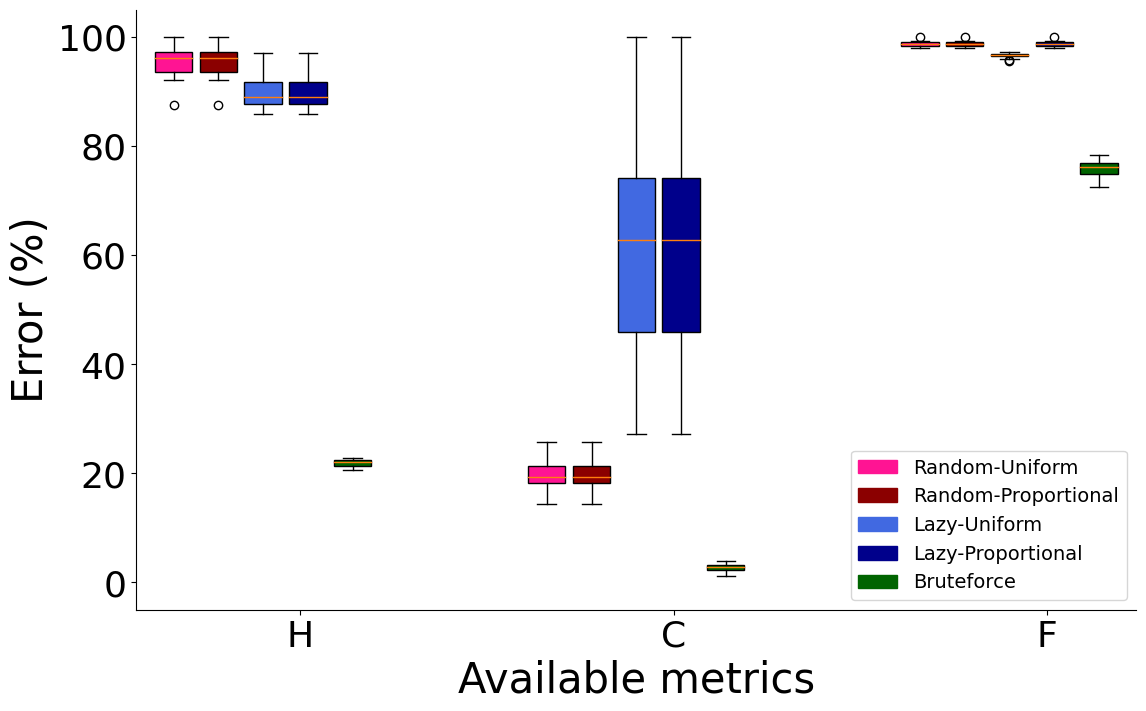

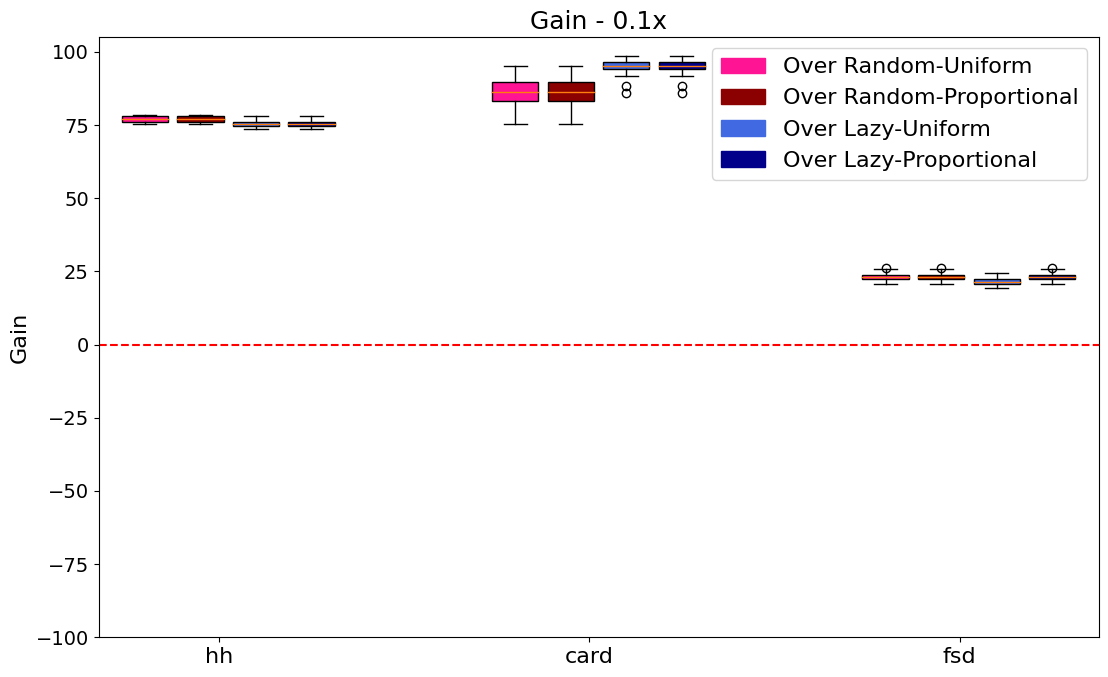

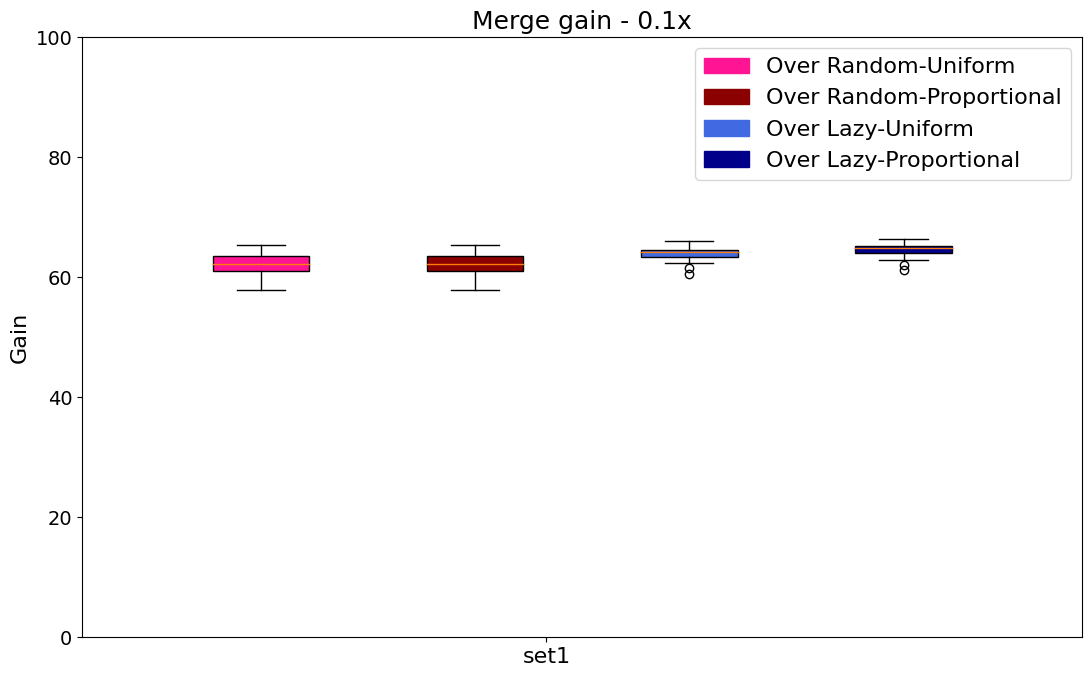

Num of run: 5
max_list: {'hh': 1984.0171264277712, 'card': 18.197732376622664, 'fsd': 1.9249998399145967}


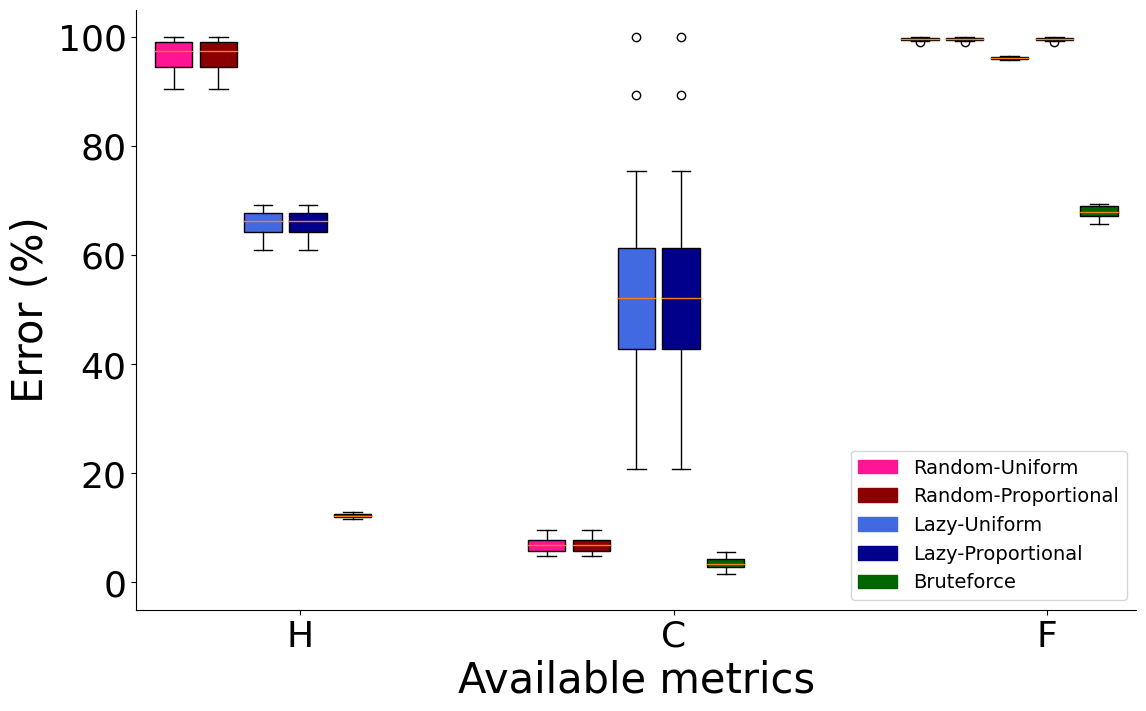

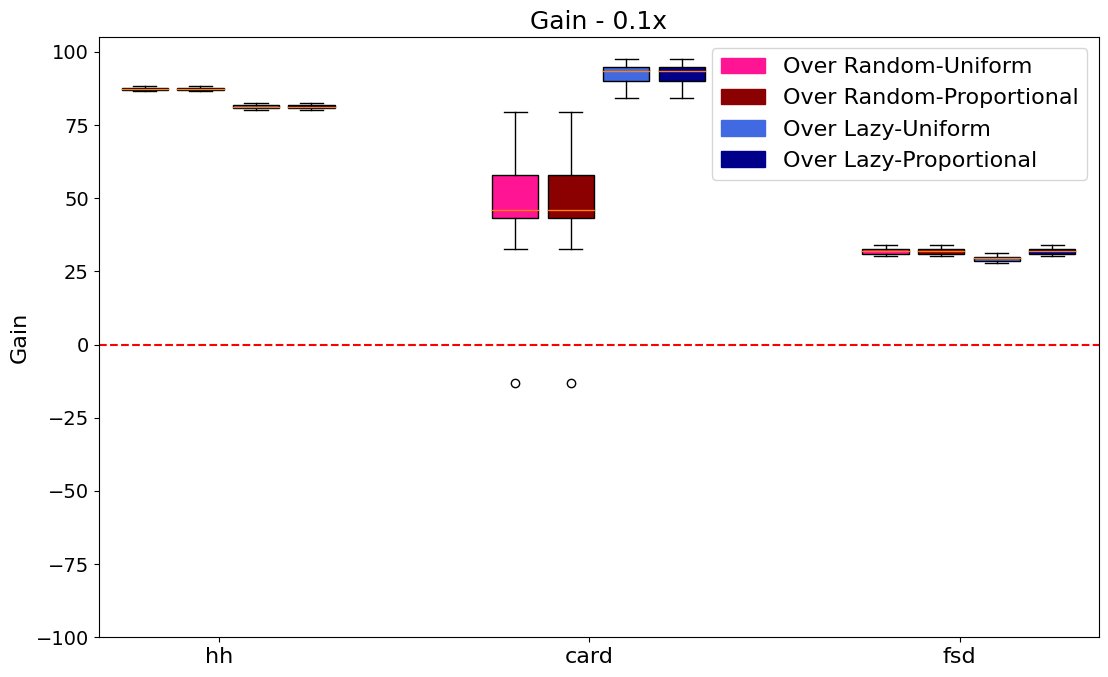

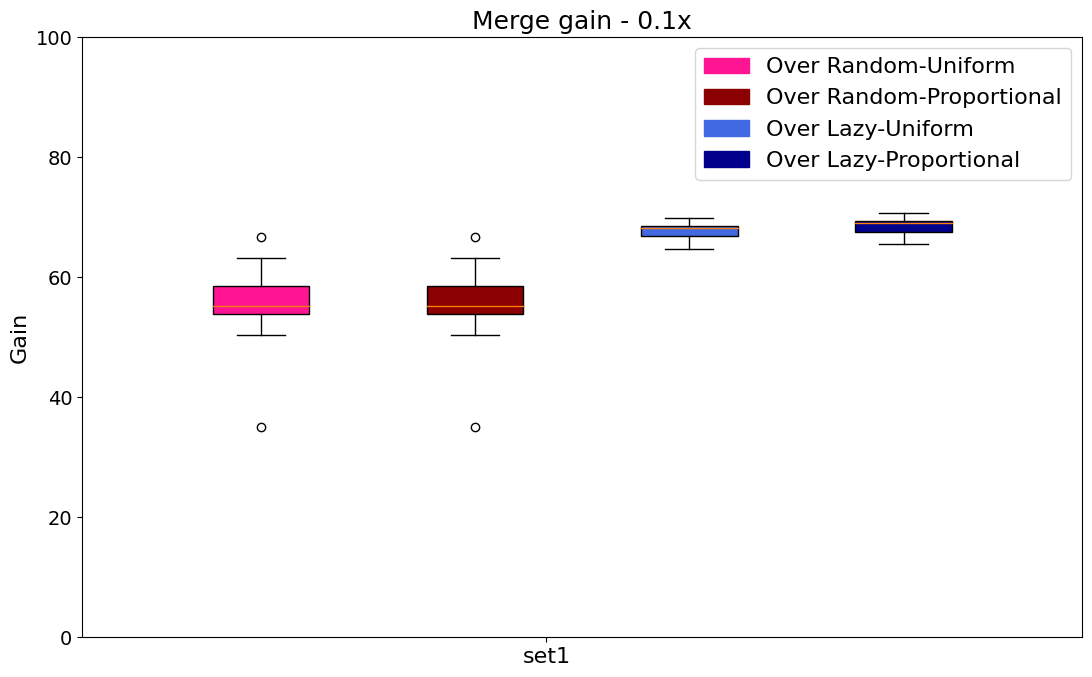

Num of run: 5
max_list: {'hh': 3686.174000679658, 'card': 20.328281578961835, 'fsd': 1.9557585729800906}


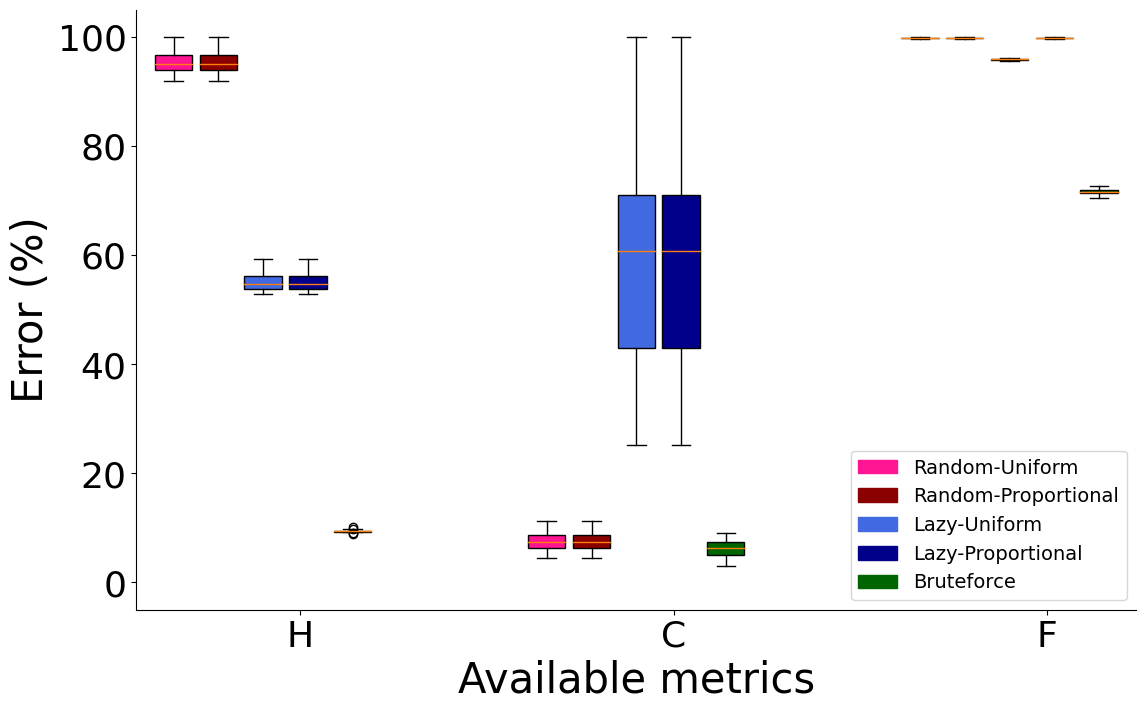

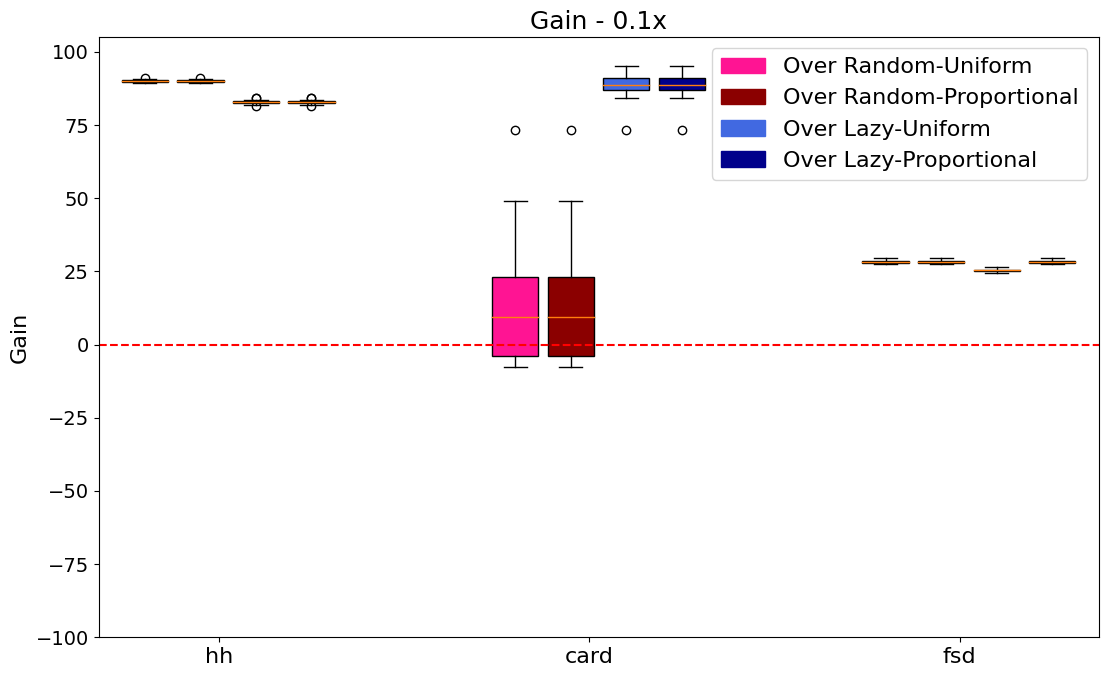

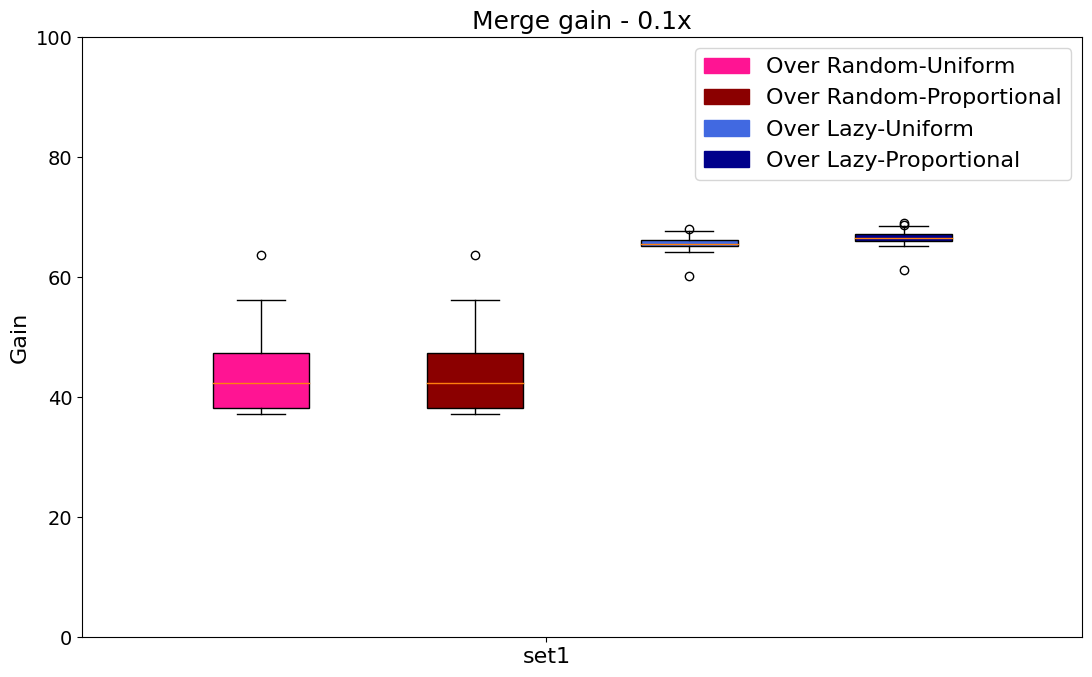

Num of run: 5
max_list: {'hh': 6937.84273381295, 'card': 21.96181046676096, 'fsd': 1.985896949754991}


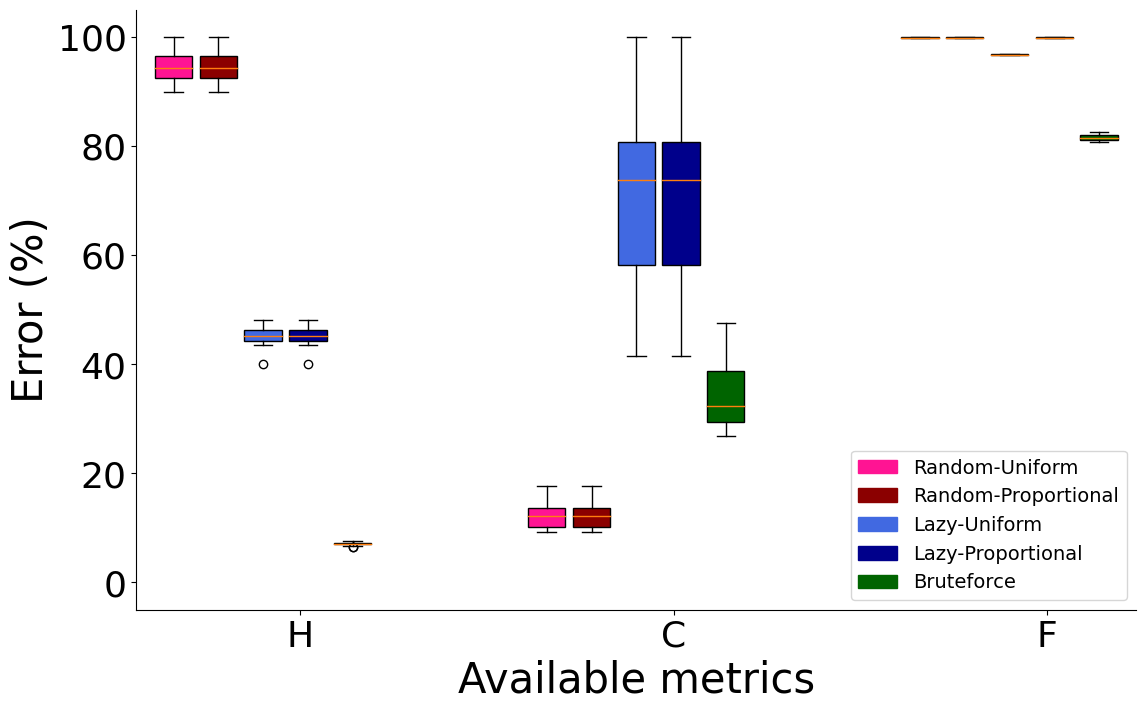

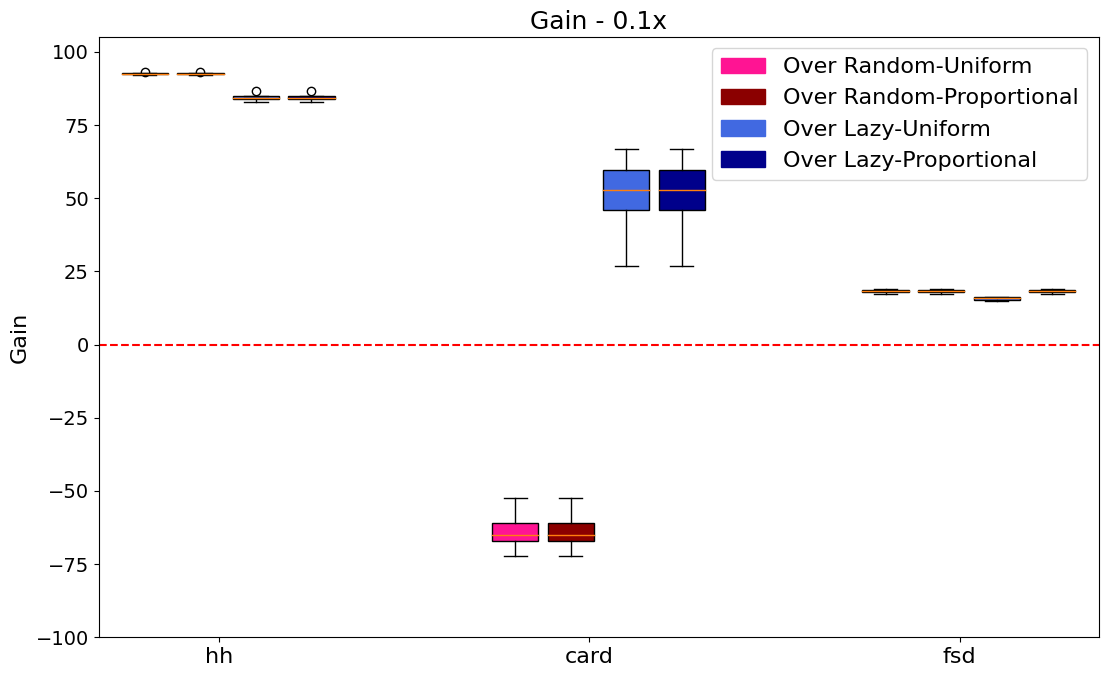

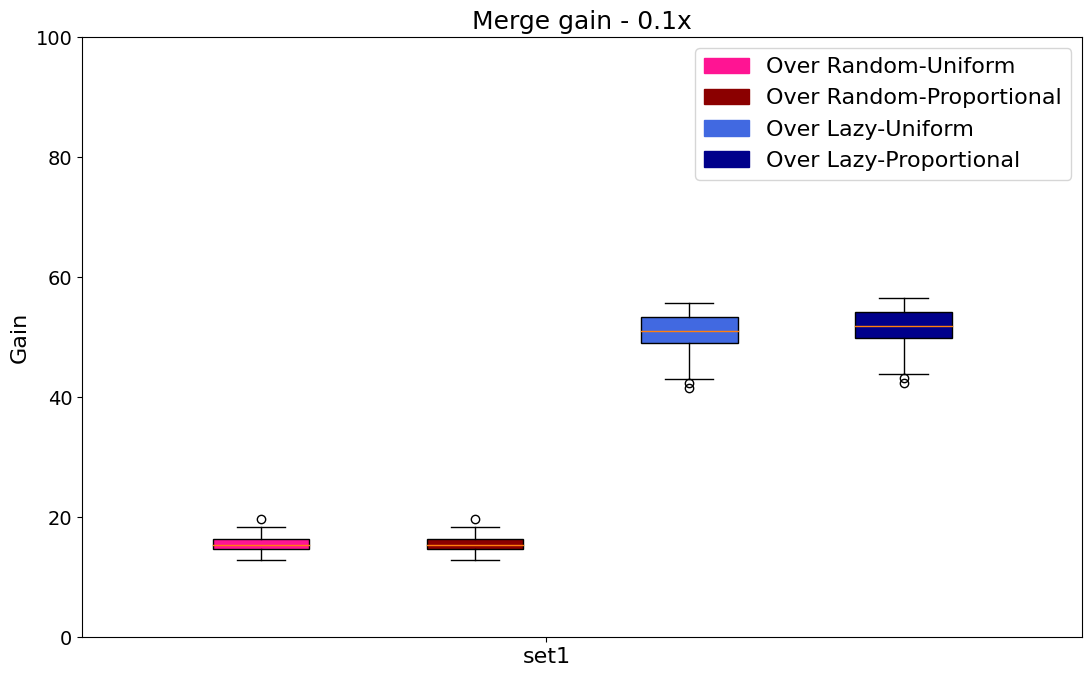

Num of run: 5
max_list: {'hh': 13047.318865248226, 'card': 54.40782929433292, 'fsd': 1.9996364029043279}


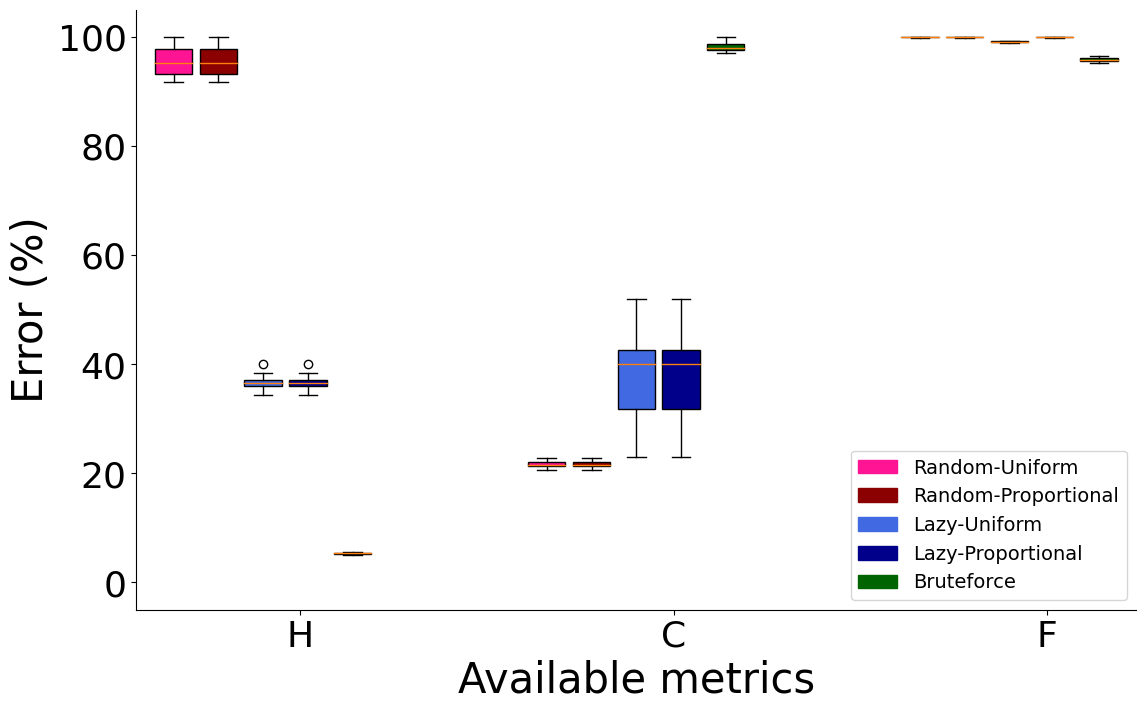

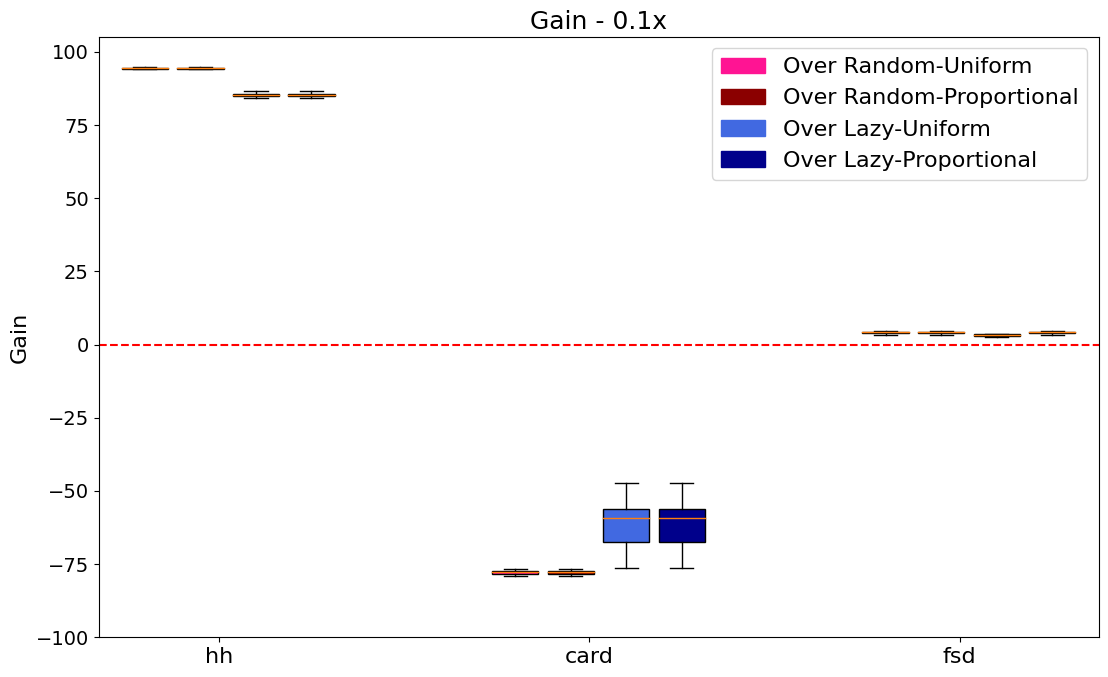

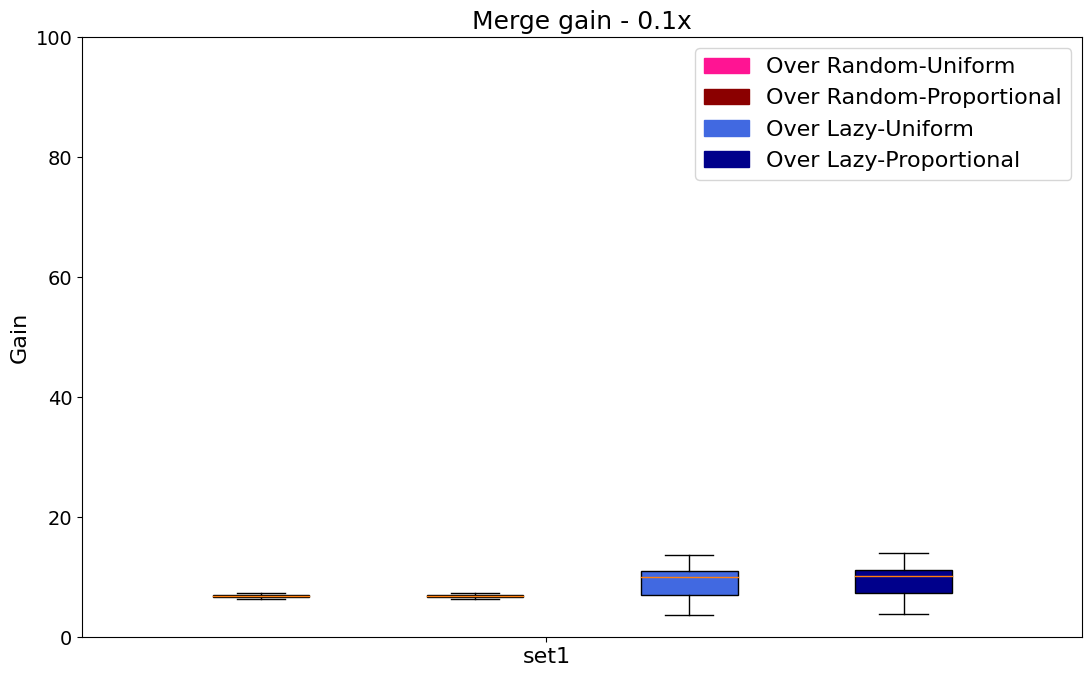

Num of run: 5
max_list: {'hh': 499.5793468965386, 'card': 14.258776551494648, 'fsd': 1.87239050067283}


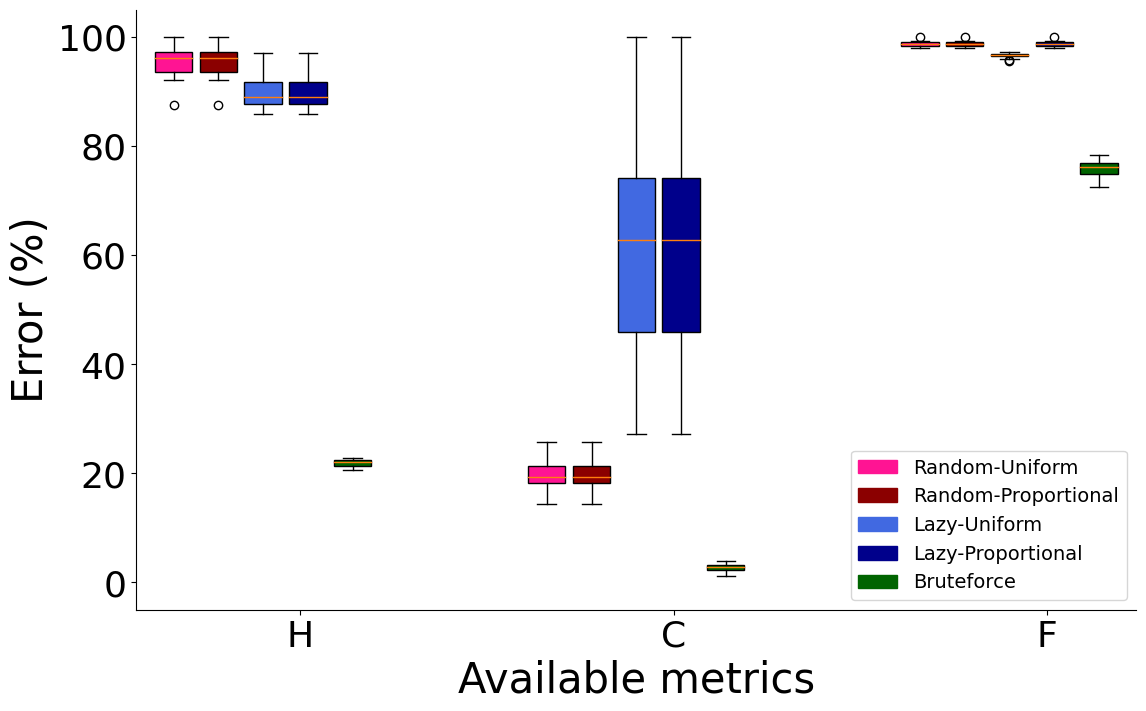

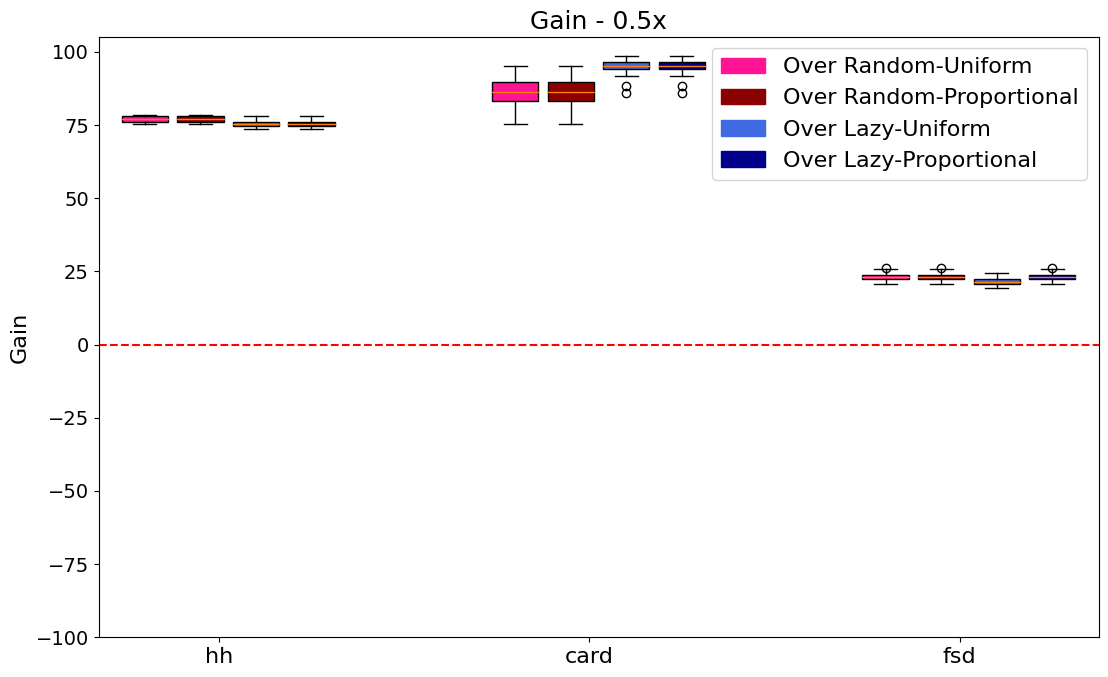

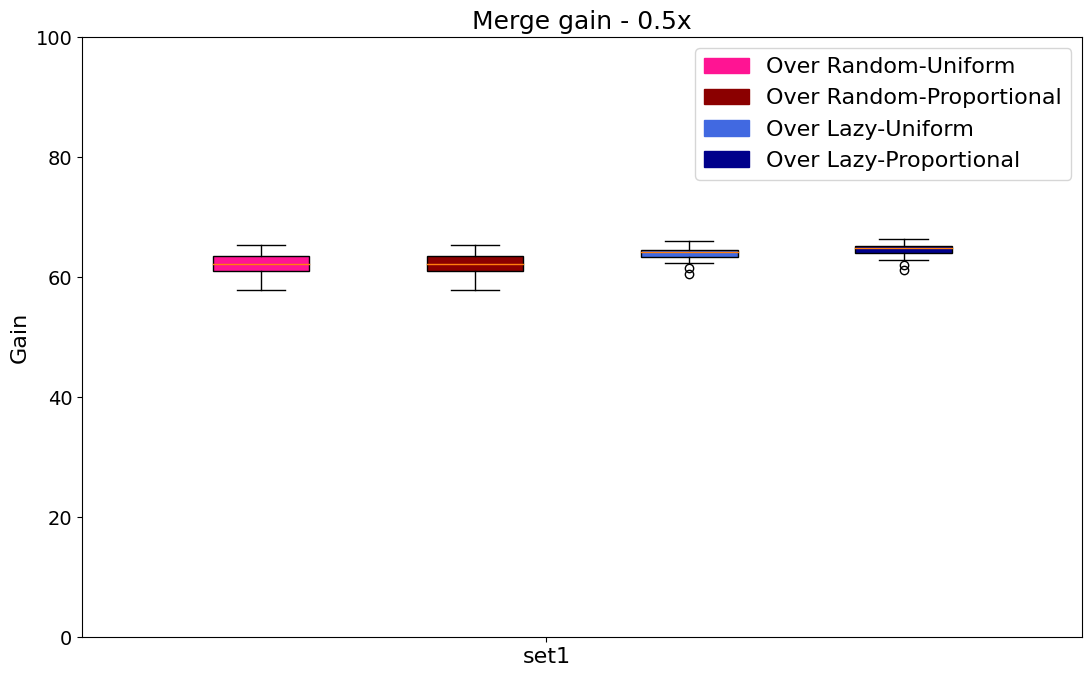

Num of run: 5
max_list: {'hh': 1984.0171264277712, 'card': 18.197732376622664, 'fsd': 1.9249998399145967}


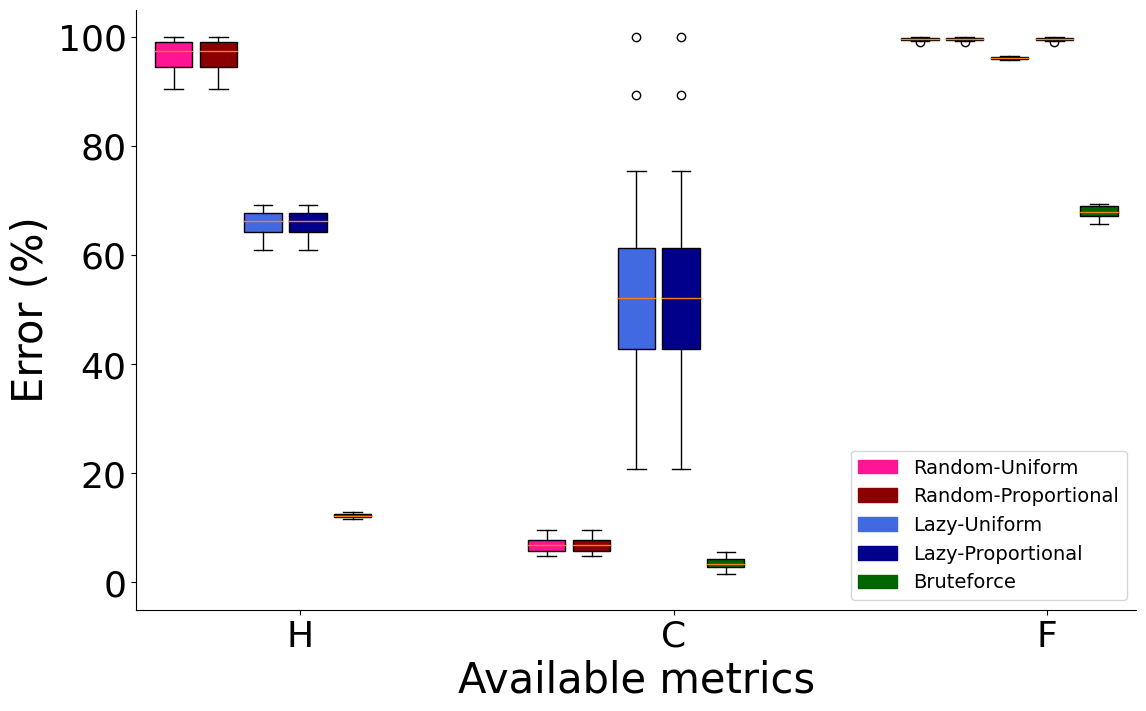

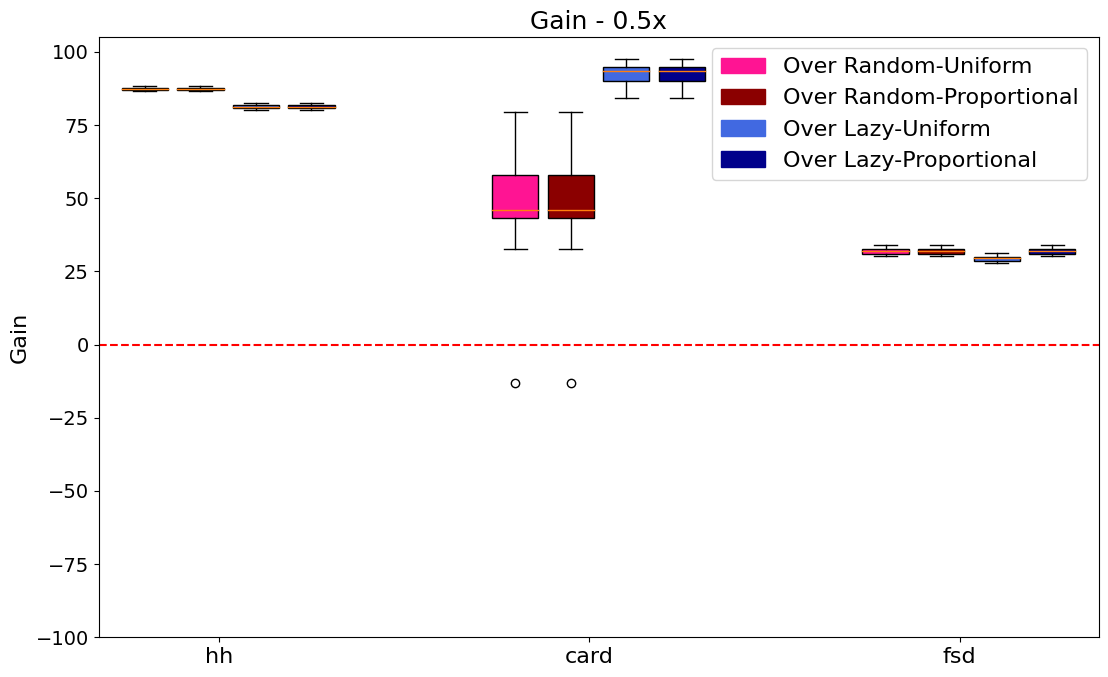

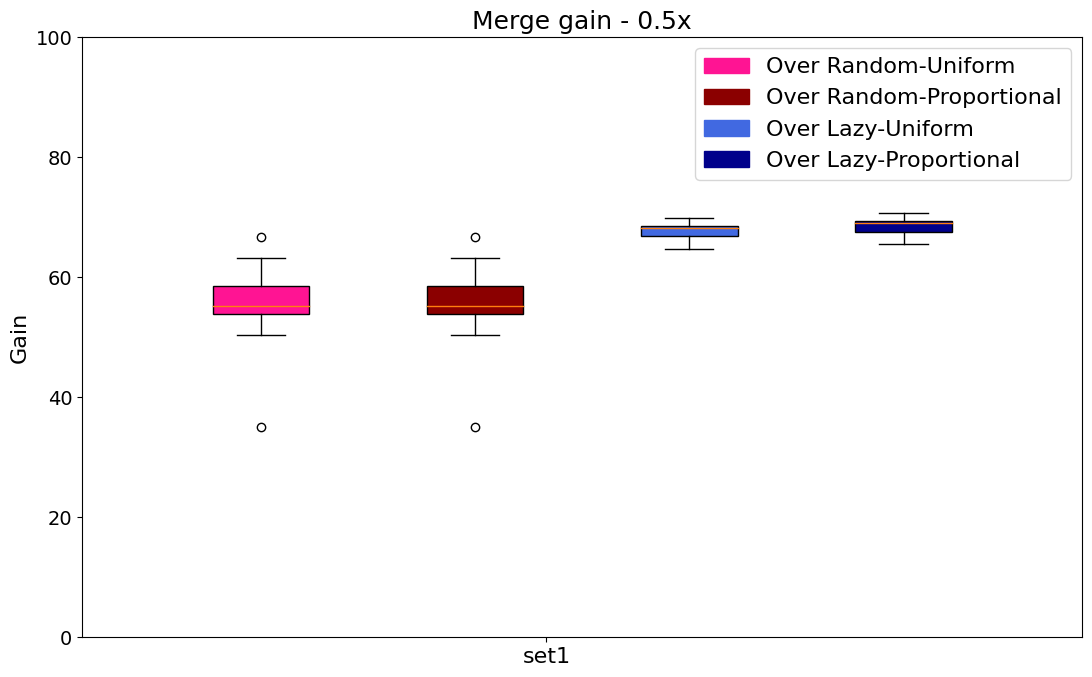

Num of run: 5
max_list: {'hh': 3686.174000679658, 'card': 20.328281578961835, 'fsd': 1.9557585729800906}


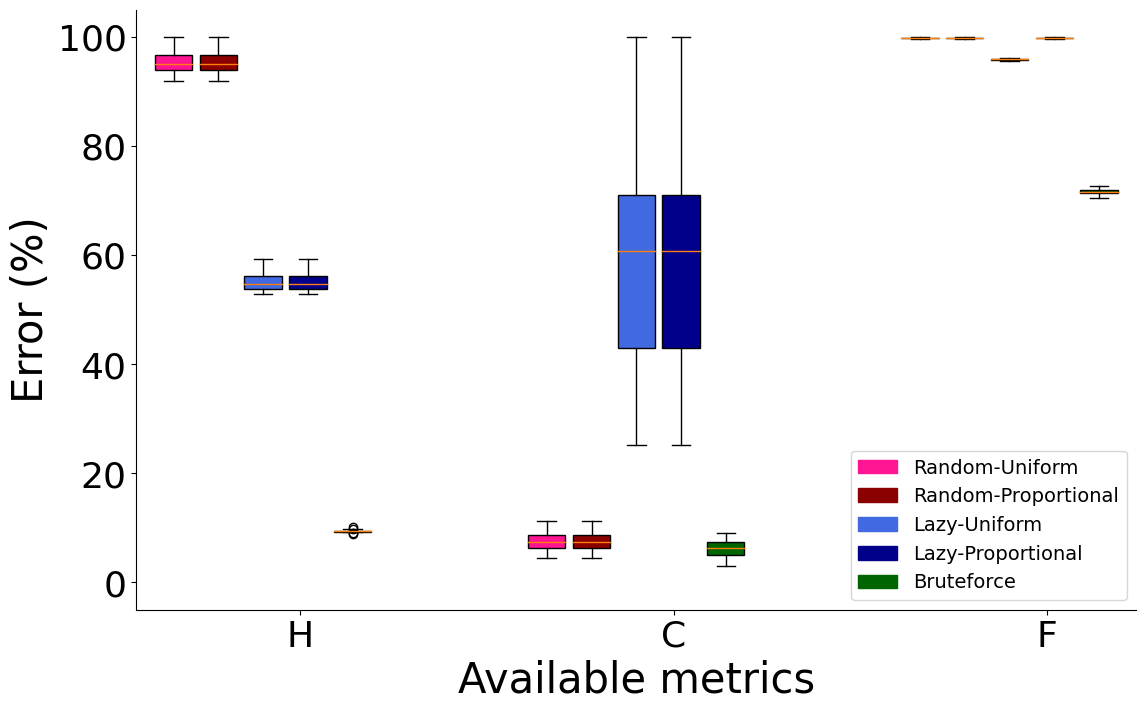

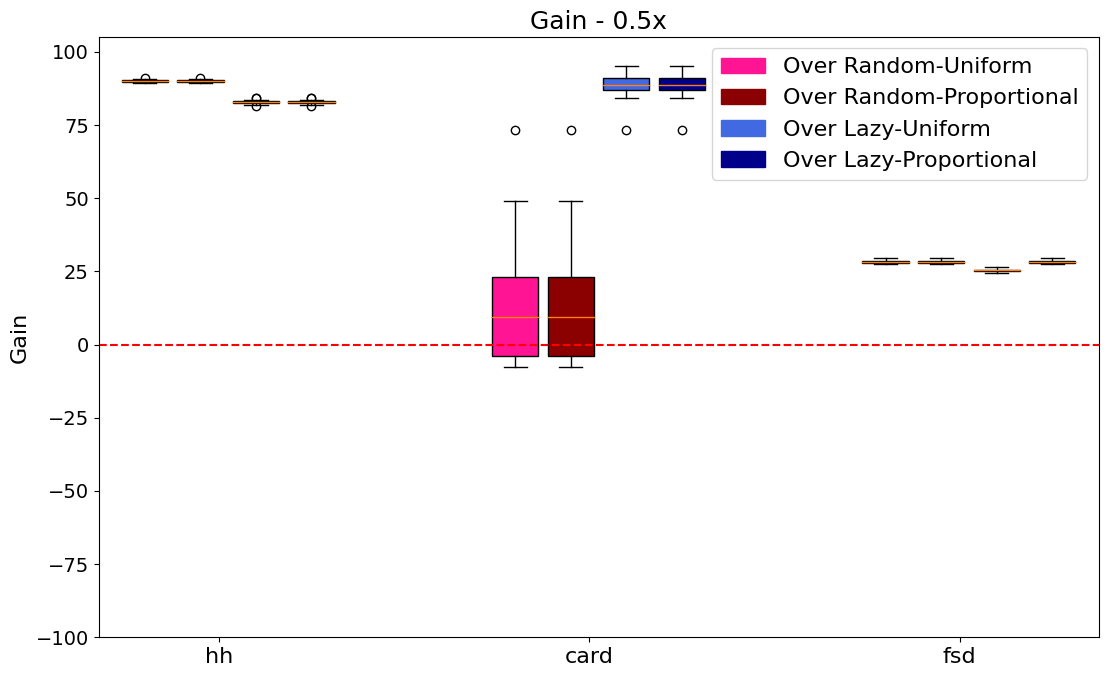

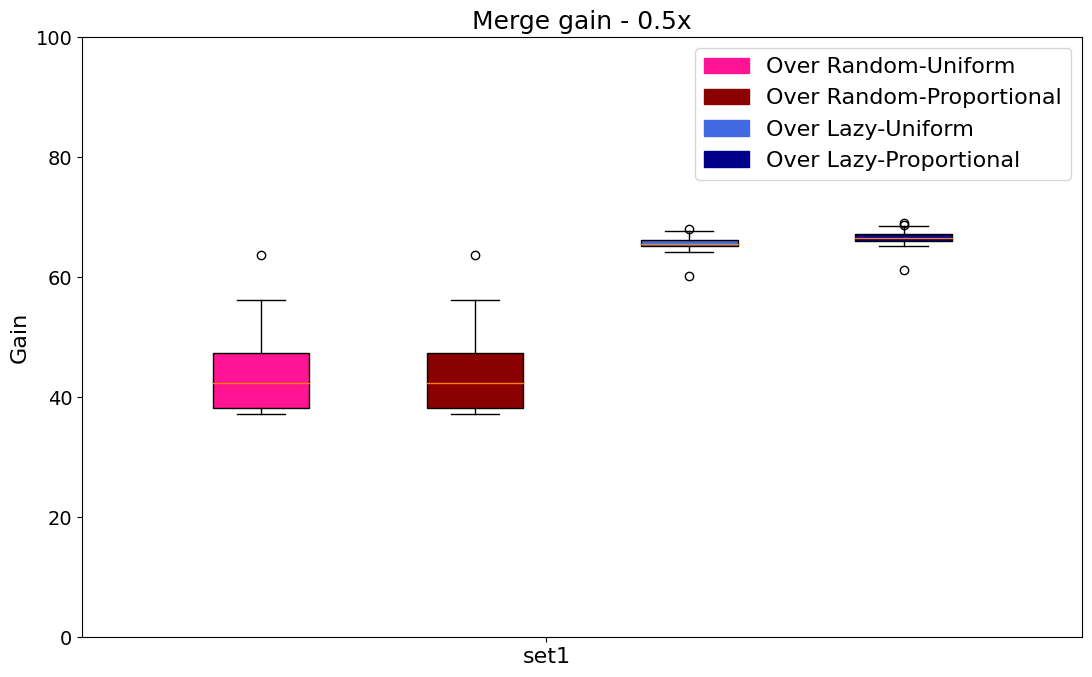

Num of run: 5
max_list: {'hh': 6937.84273381295, 'card': 21.96181046676096, 'fsd': 1.985896949754991}


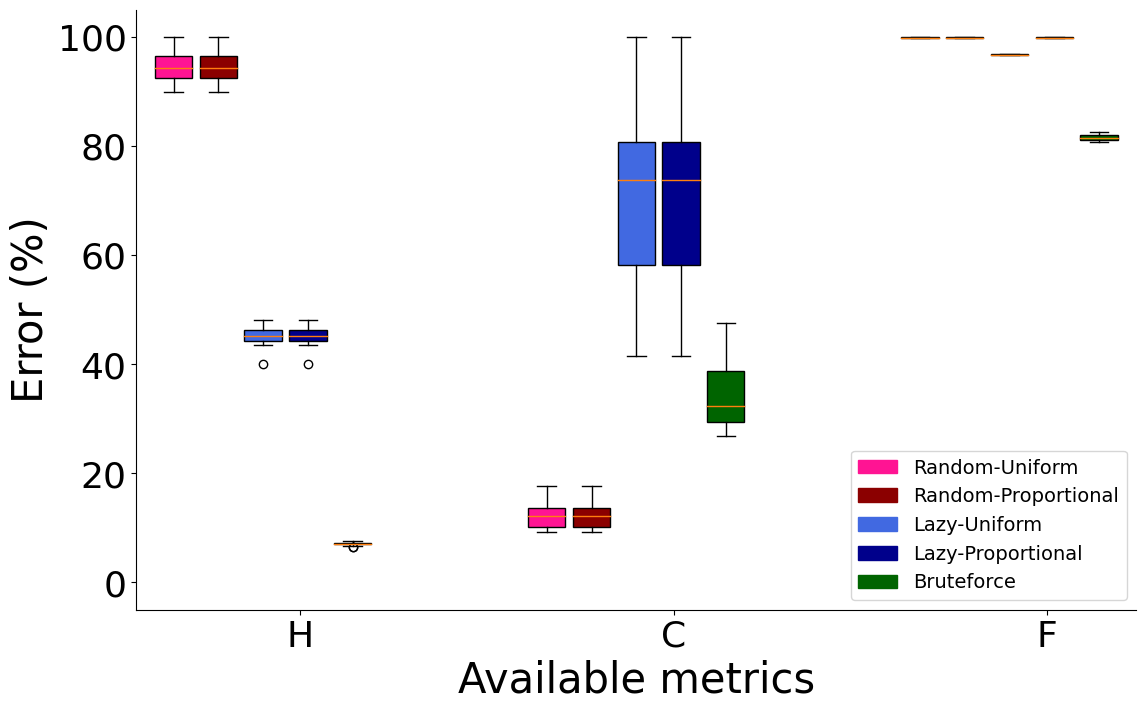

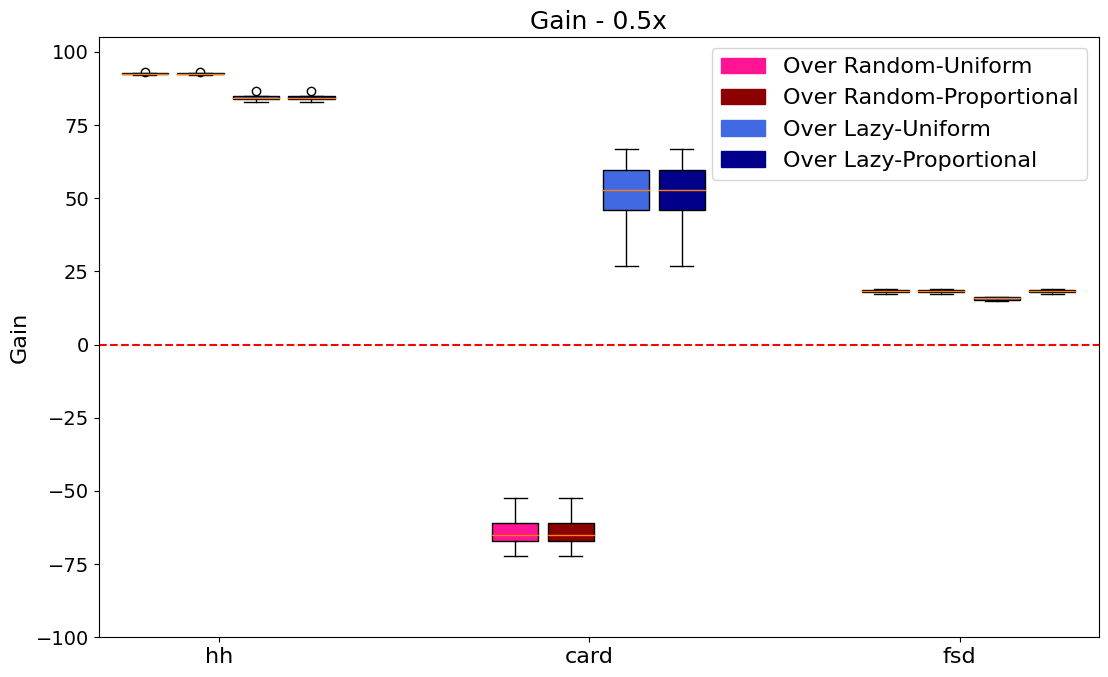

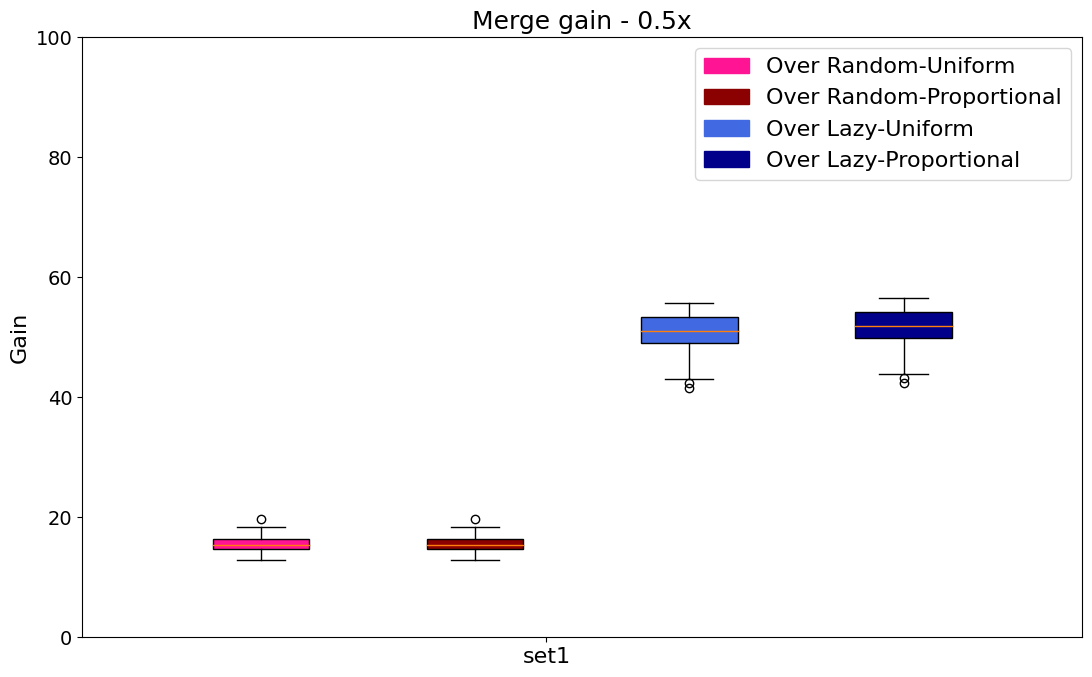

Num of run: 5
max_list: {'hh': 13047.318865248226, 'card': 54.40782929433292, 'fsd': 1.9996364029043279}


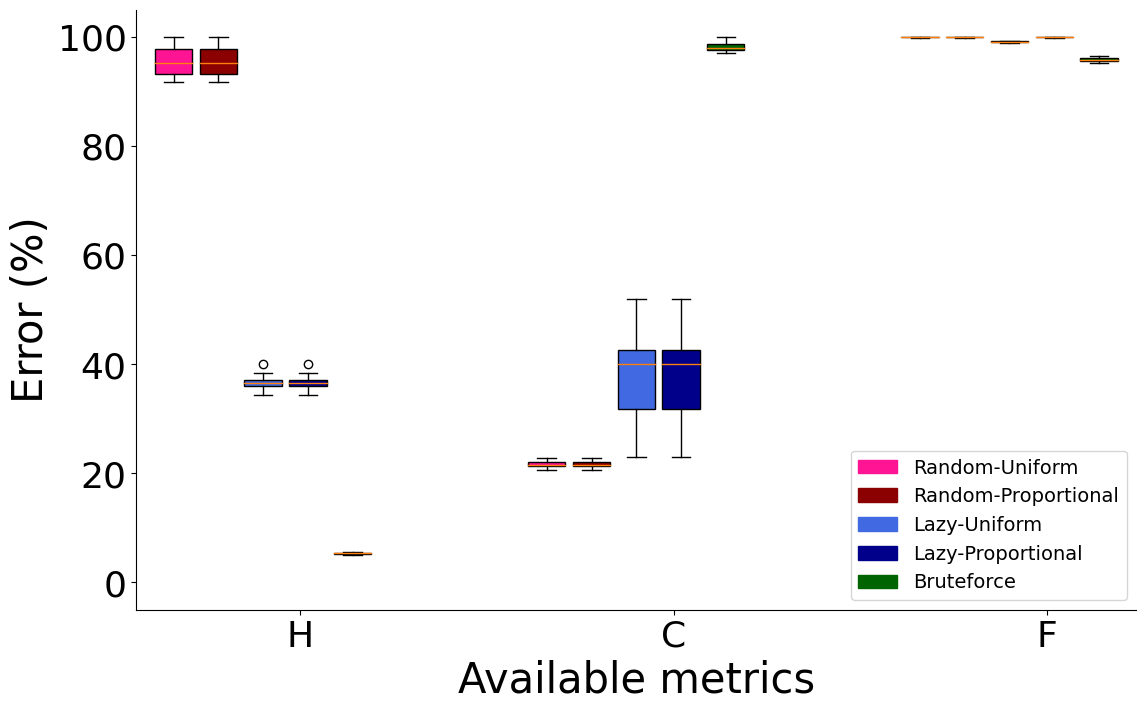

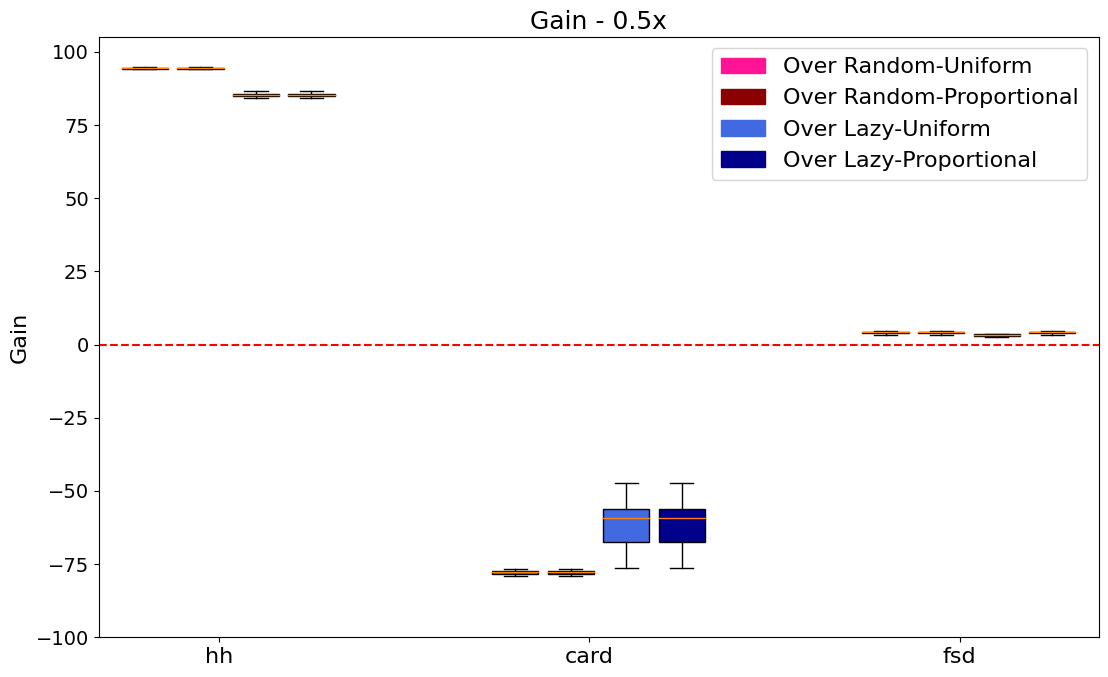

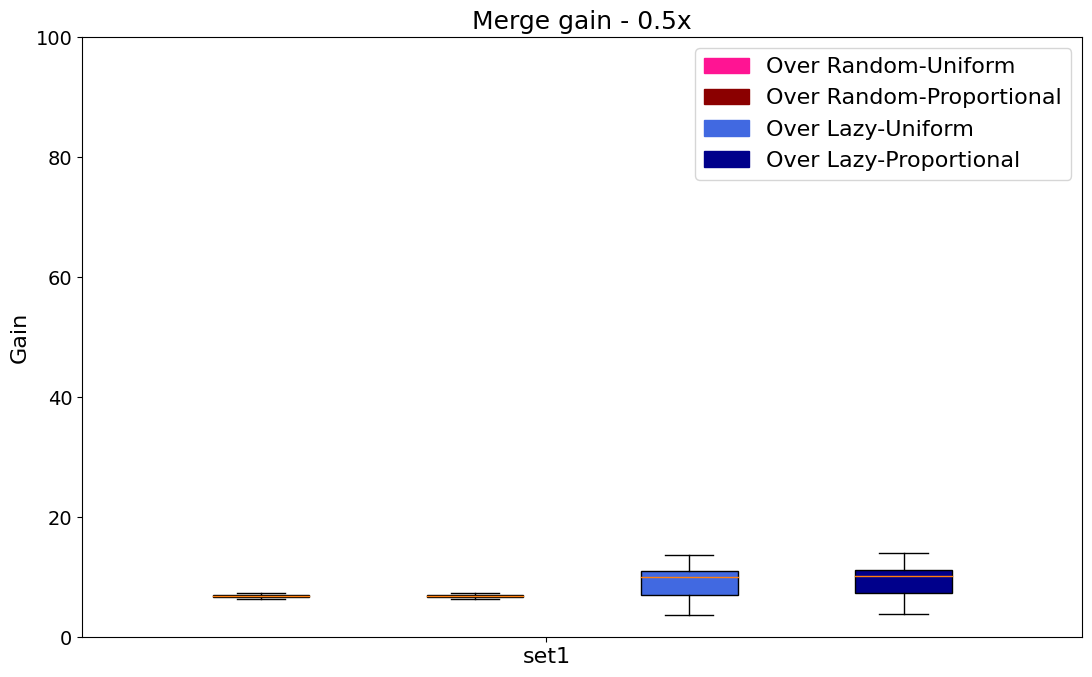

Num of run: 5
max_list: {'hh': 499.5793468965386, 'card': 14.258776551494648, 'fsd': 1.87239050067283}


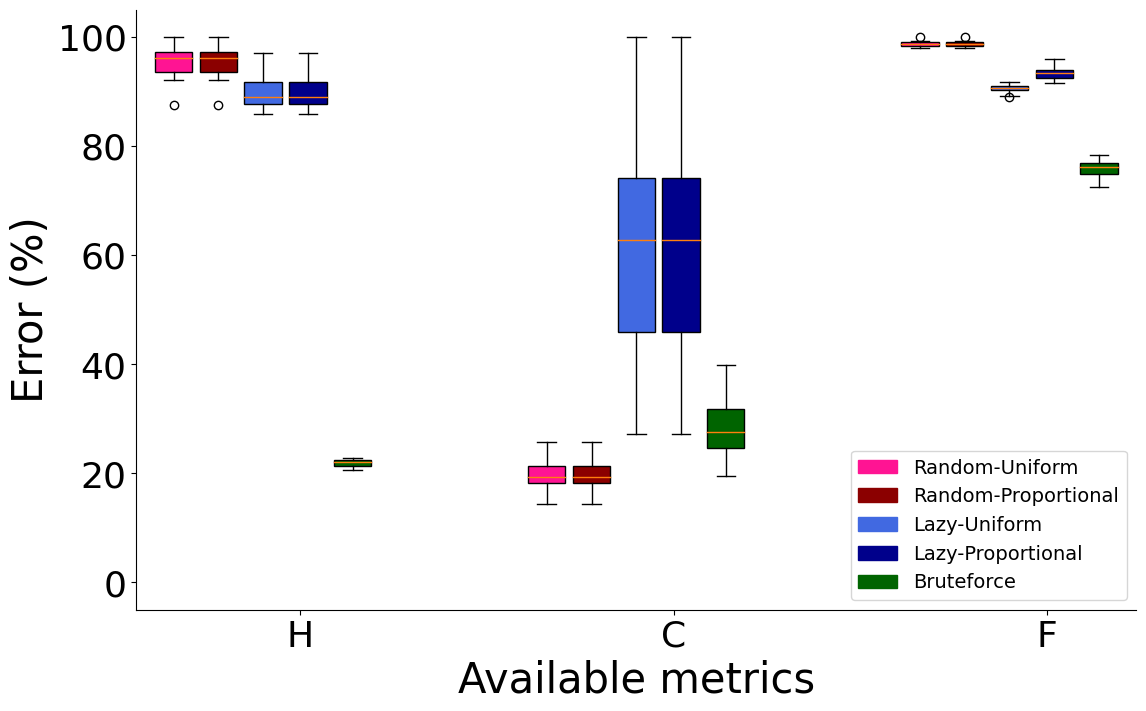

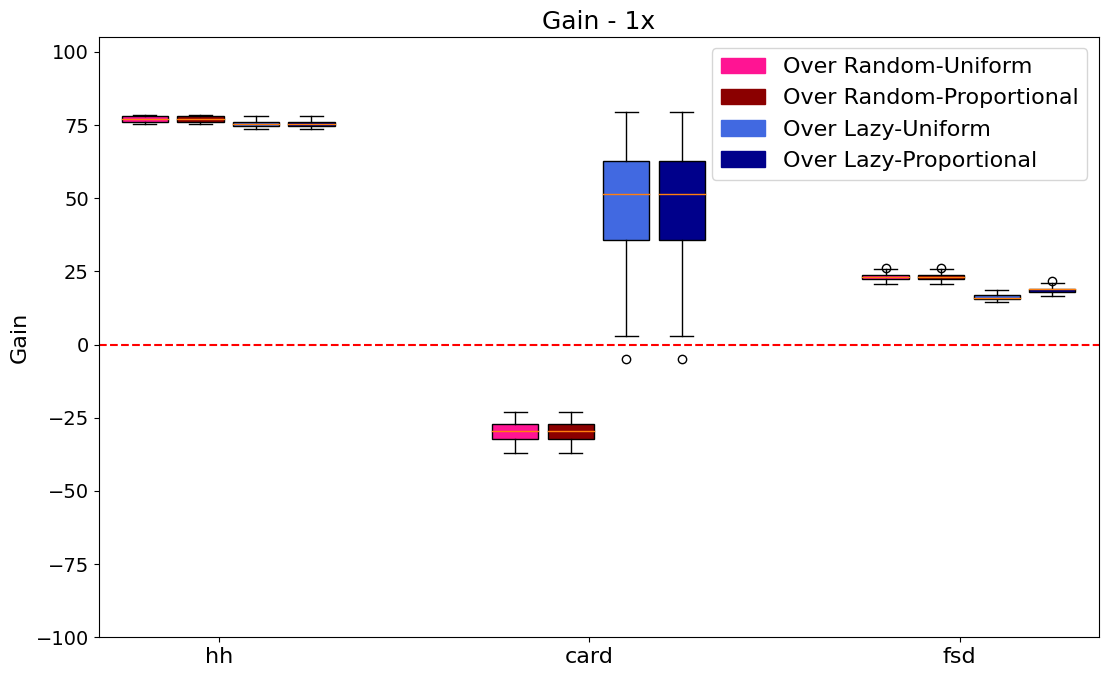

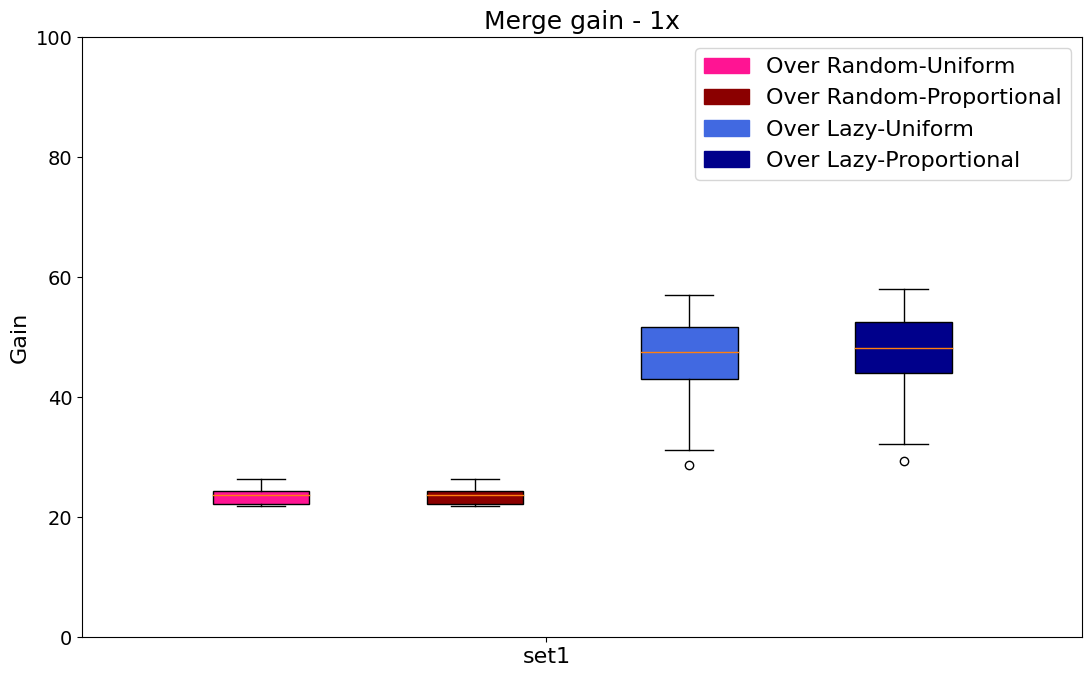

Num of run: 5
max_list: {'hh': 1984.0171264277712, 'card': 18.197732376622664, 'fsd': 1.9249998399145967}


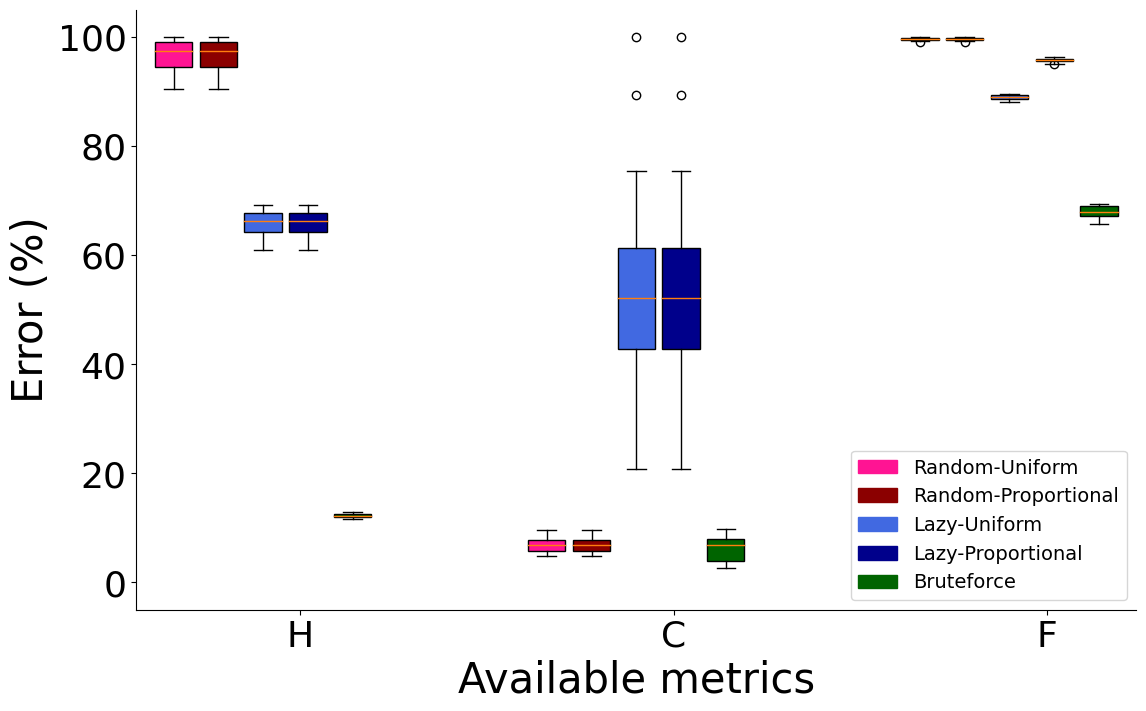

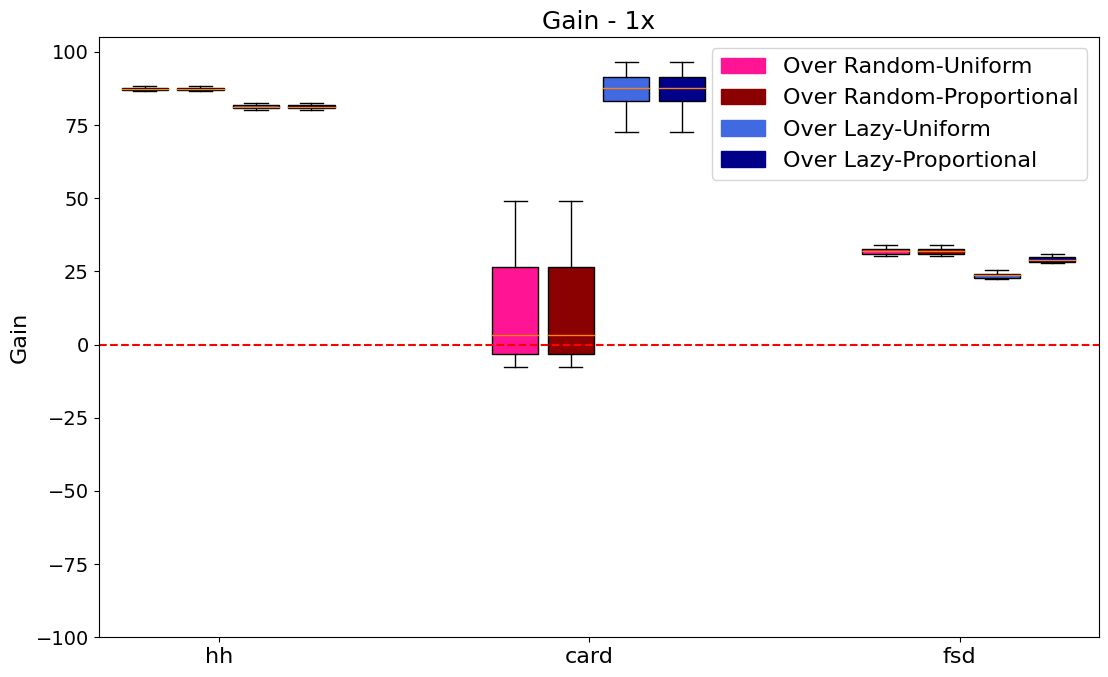

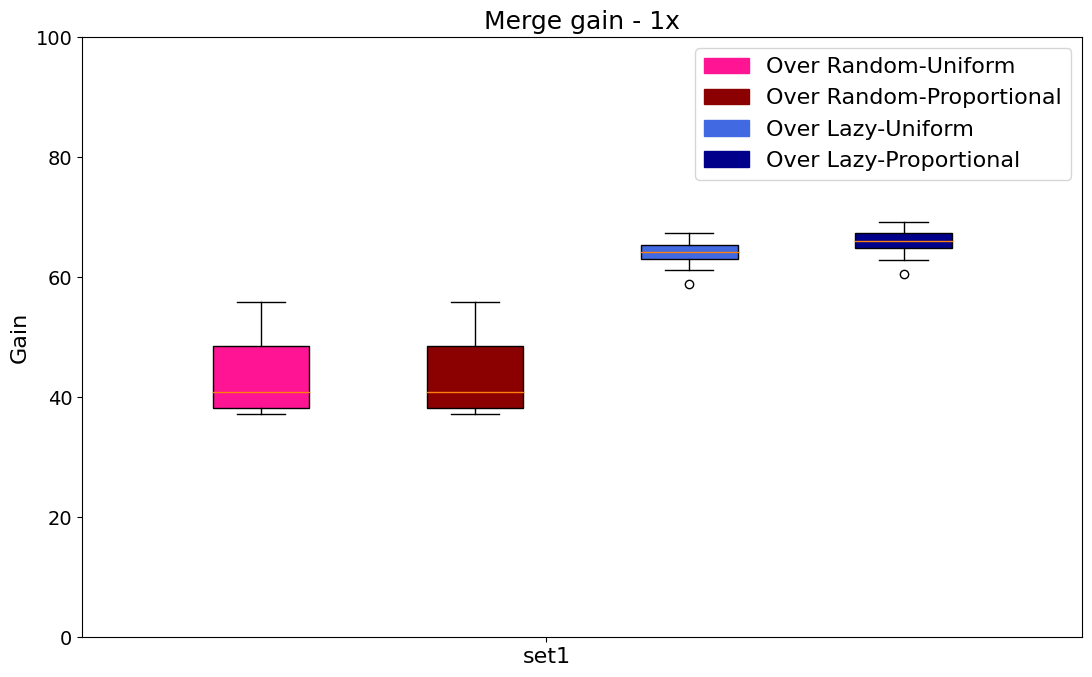

Num of run: 5
max_list: {'hh': 3686.174000679658, 'card': 20.328281578961835, 'fsd': 1.9557585729800906}


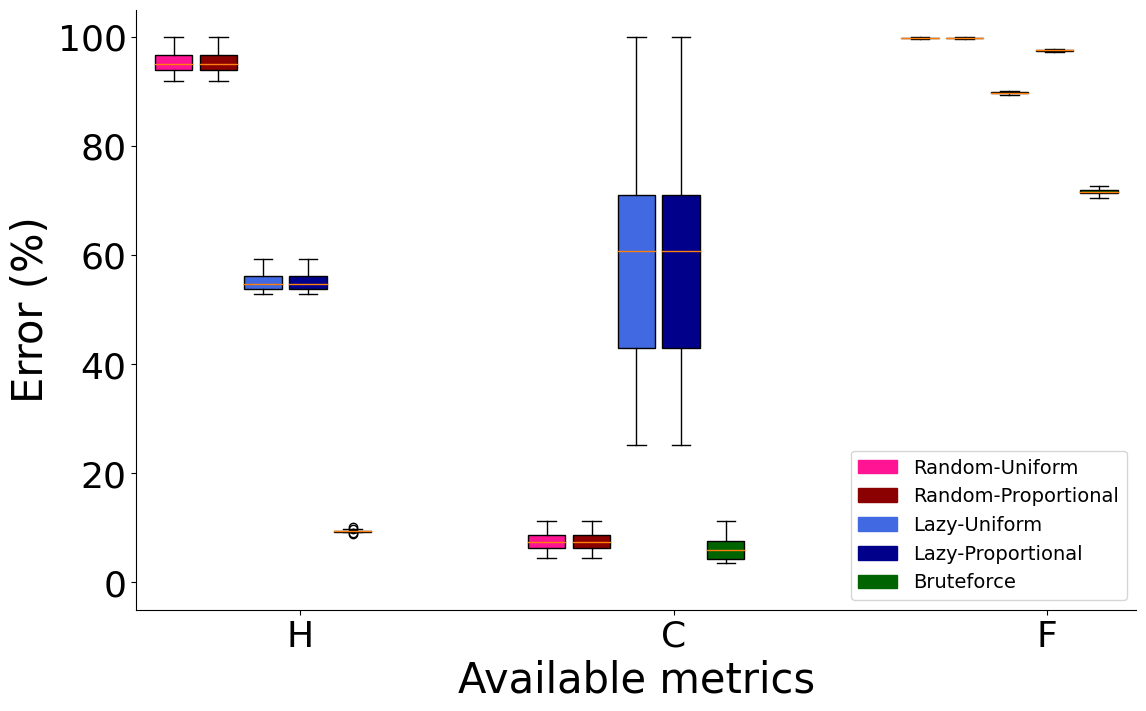

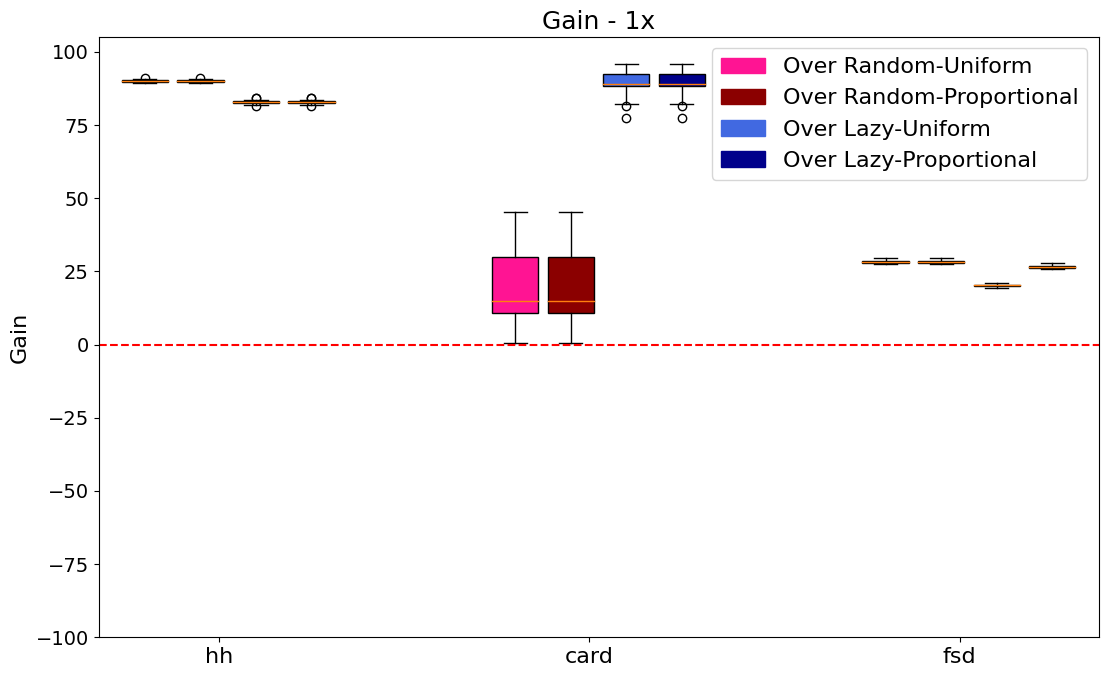

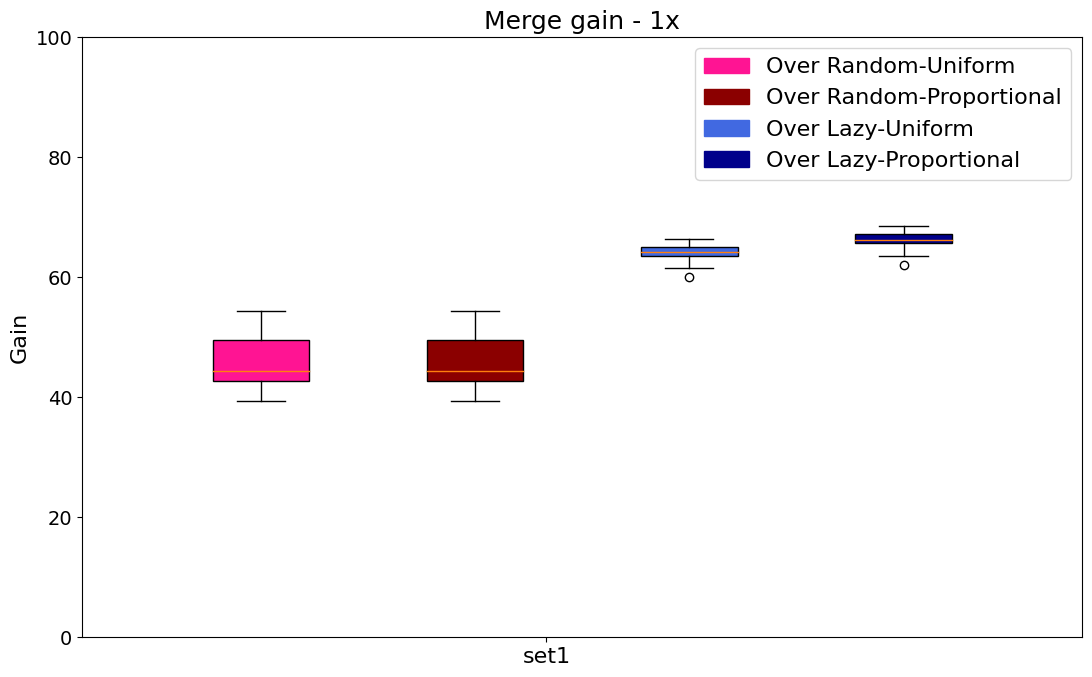

Num of run: 5
max_list: {'hh': 6937.84273381295, 'card': 21.96181046676096, 'fsd': 1.9858969497549908}


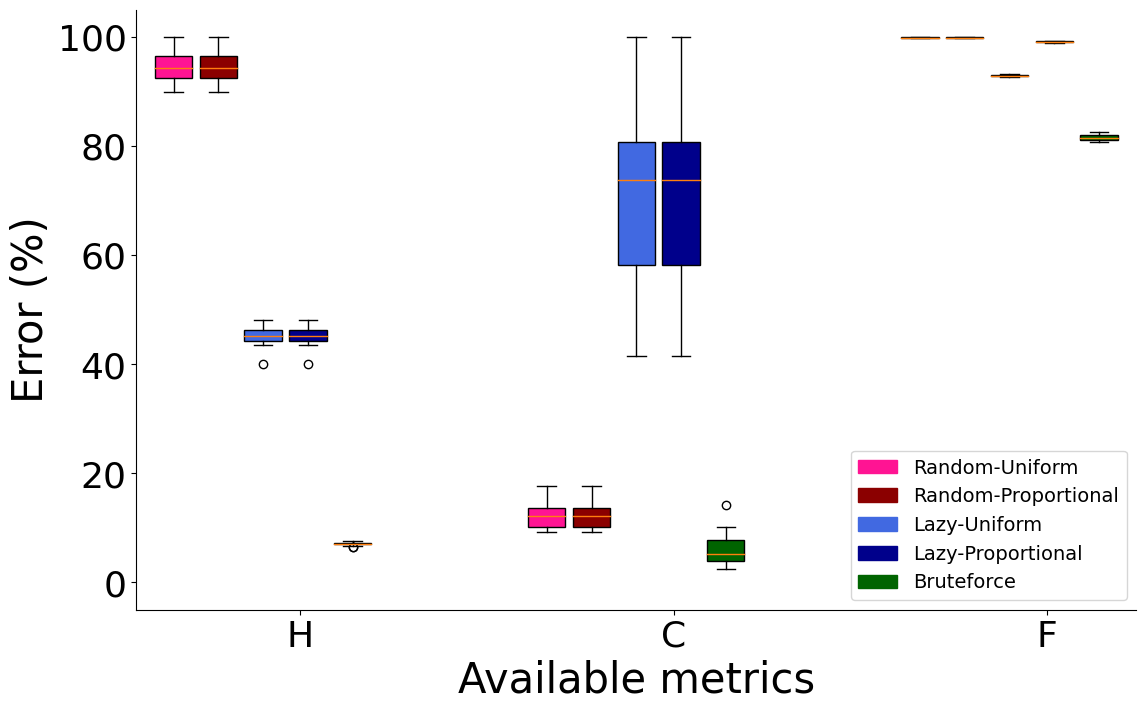

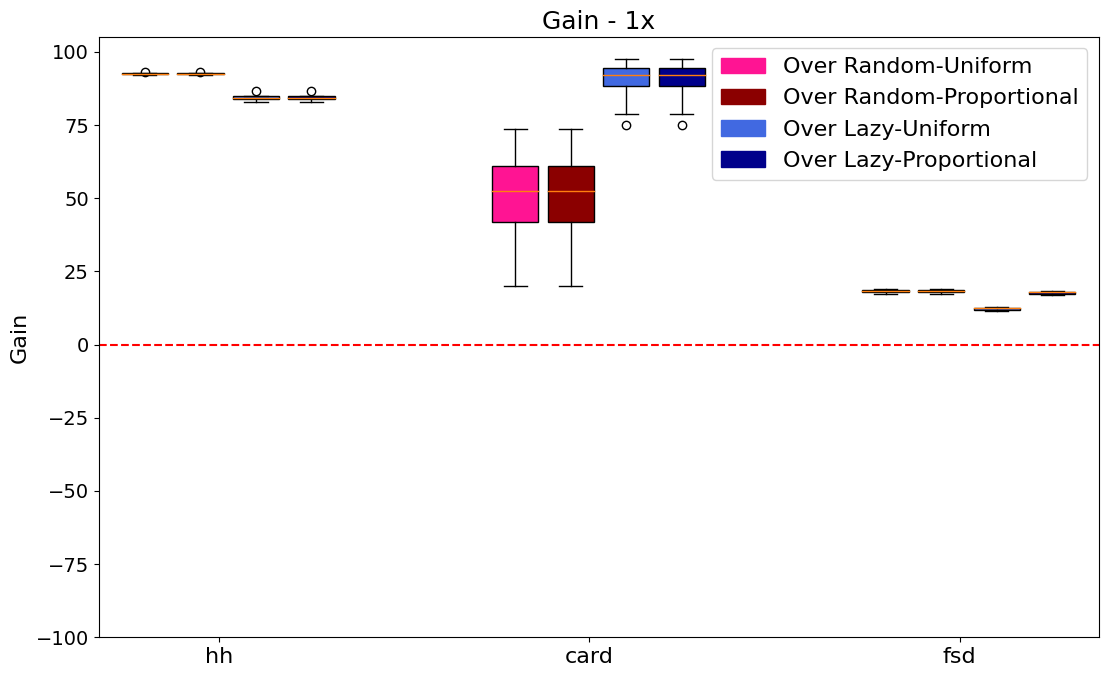

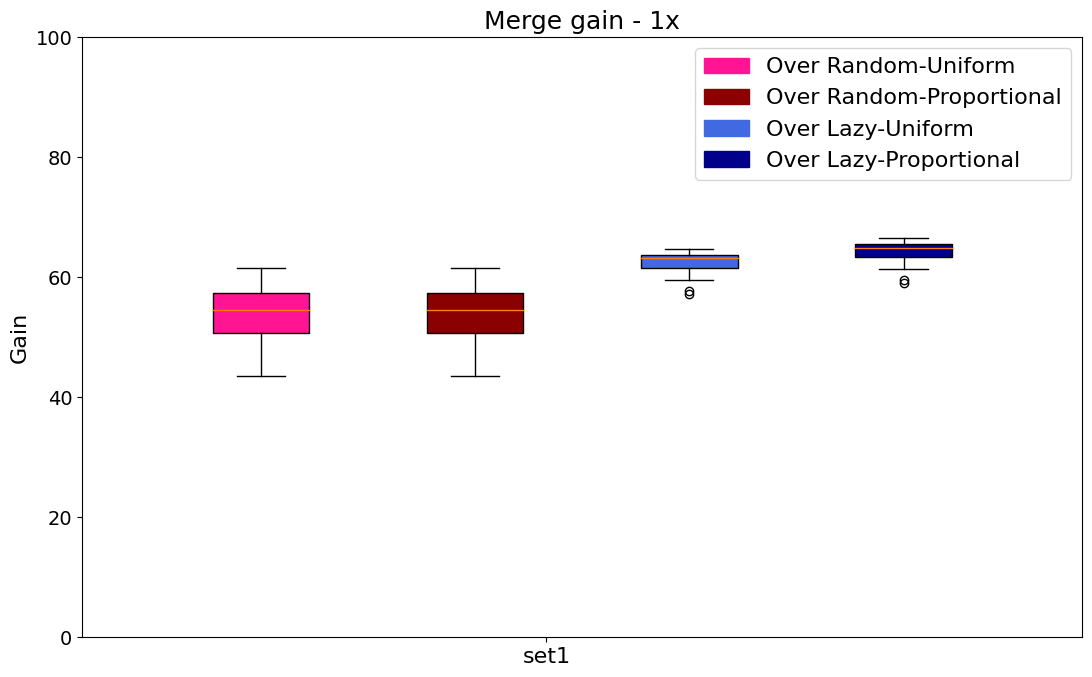

Num of run: 5
max_list: {'hh': 13047.318865248226, 'card': 28.28263372419777, 'fsd': 1.9996364029043279}


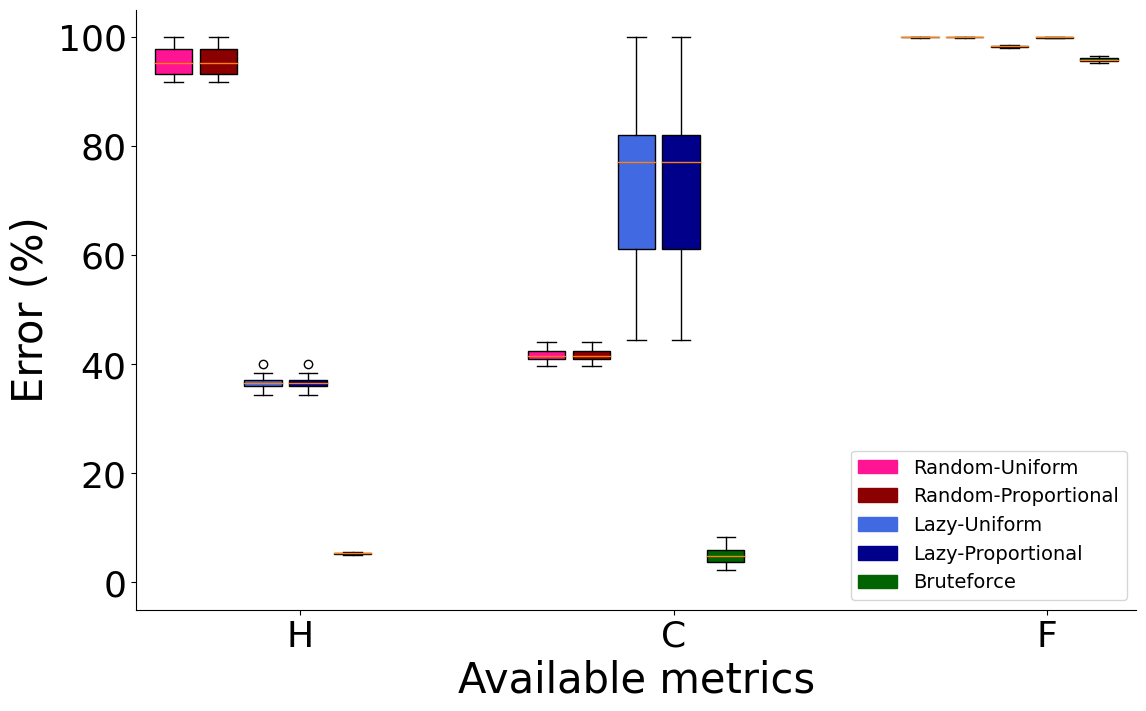

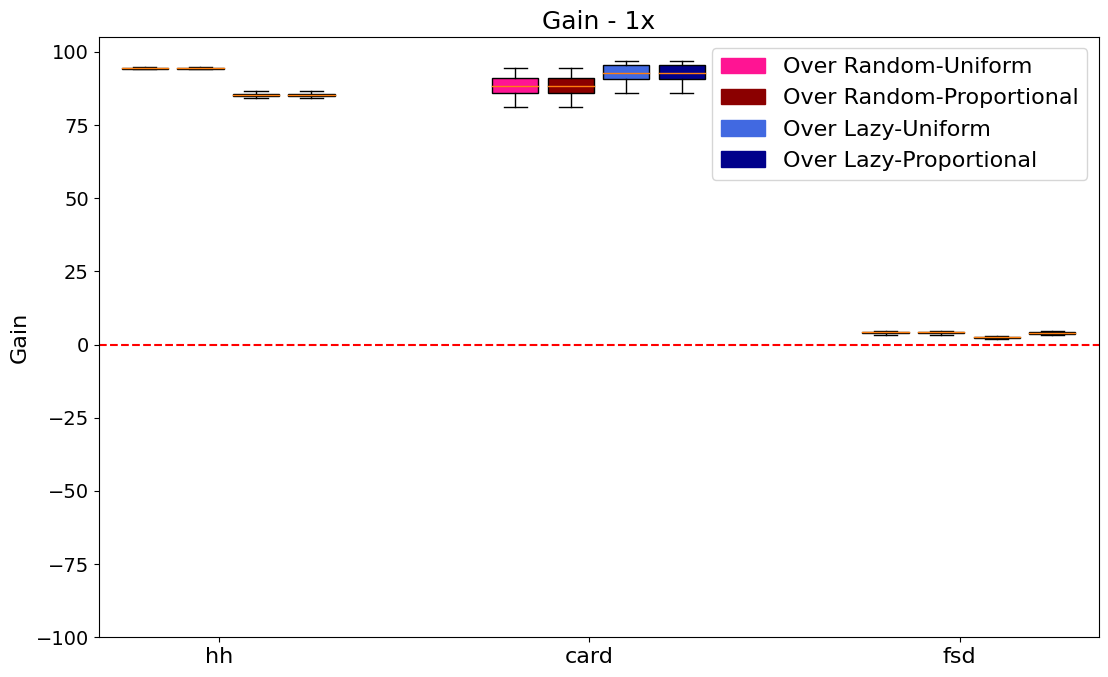

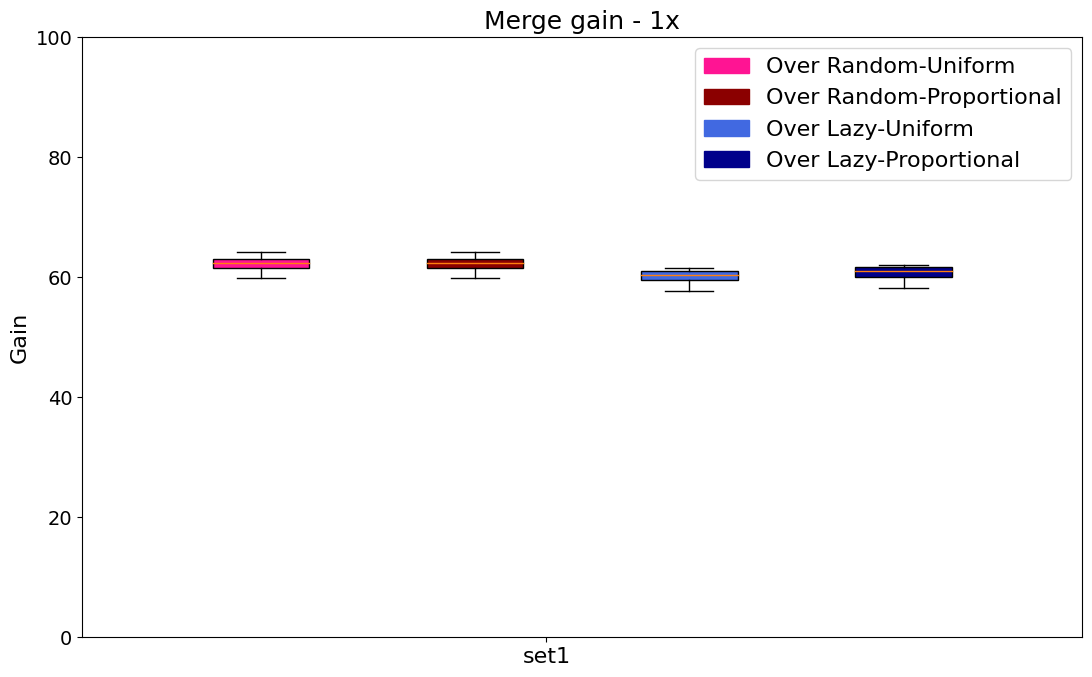

Num of run: 5
max_list: {'hh': 499.5793468965386, 'card': 14.258776551494648, 'fsd': 1.87239050067283}


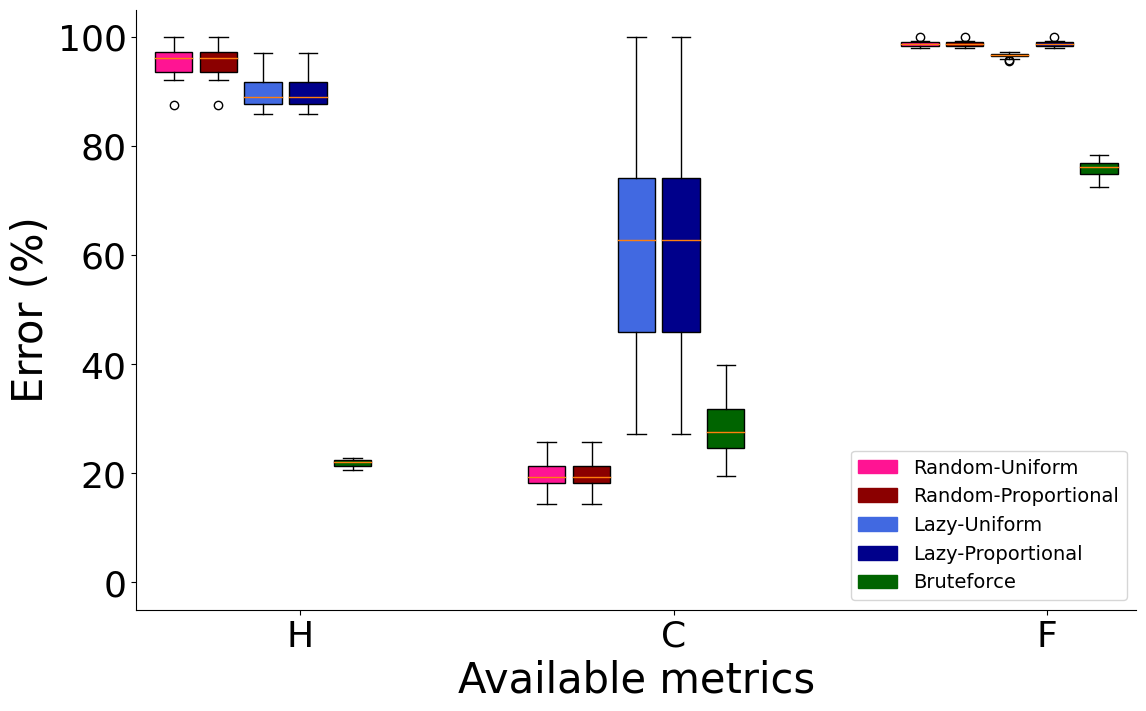

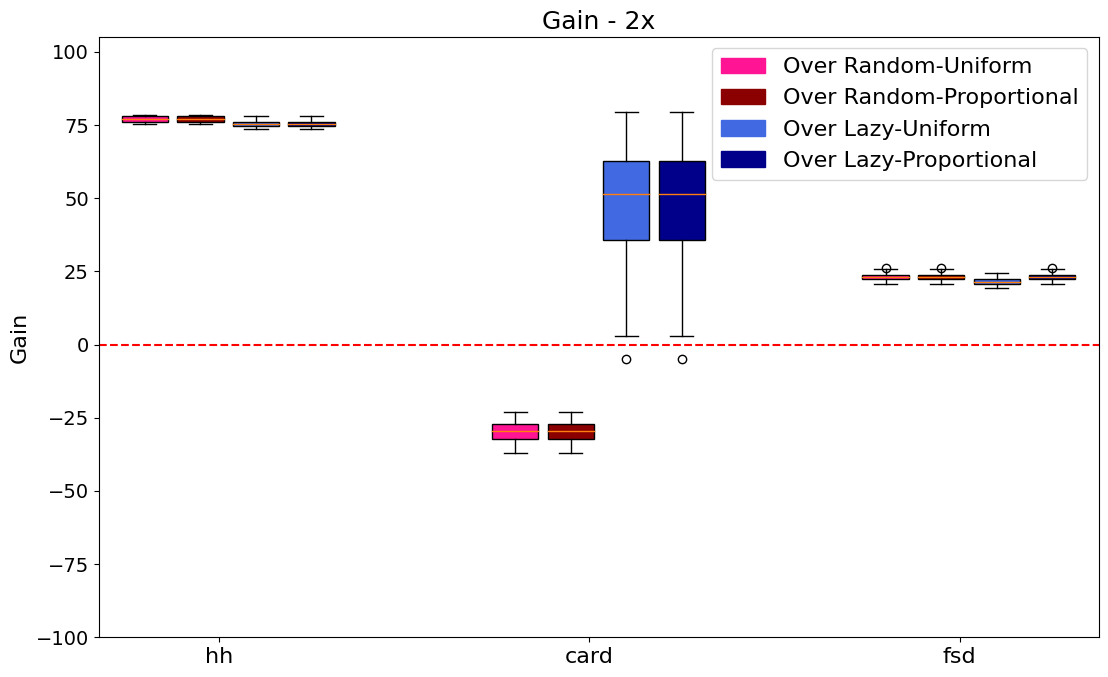

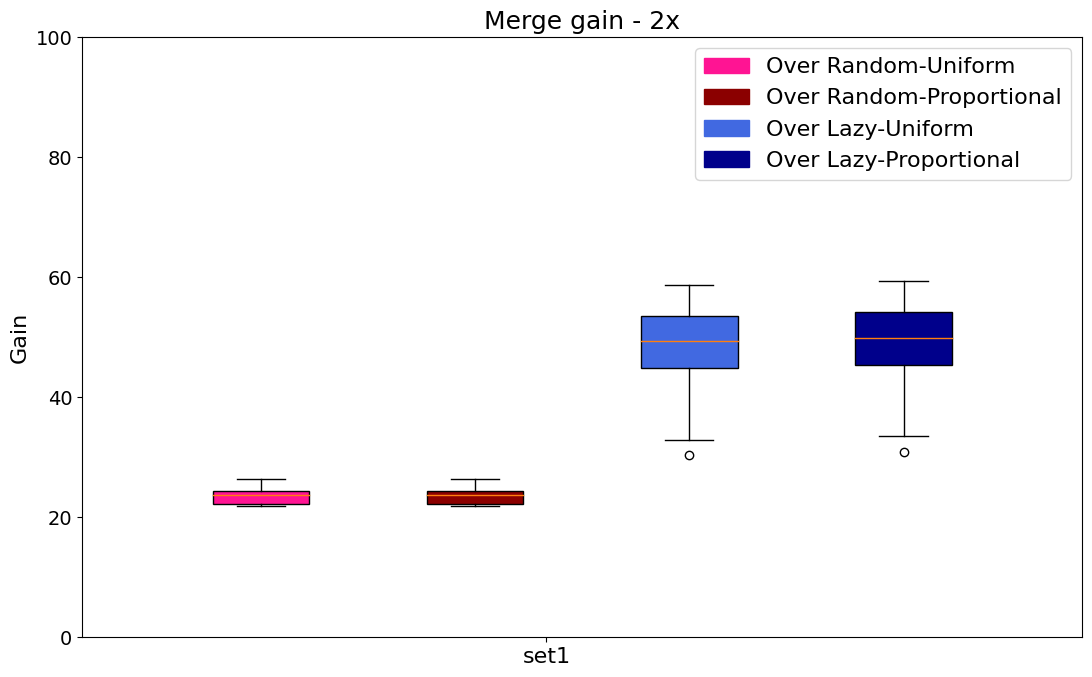

Num of run: 5
max_list: {'hh': 1984.0171264277712, 'card': 18.197732376622664, 'fsd': 1.9249998399145967}


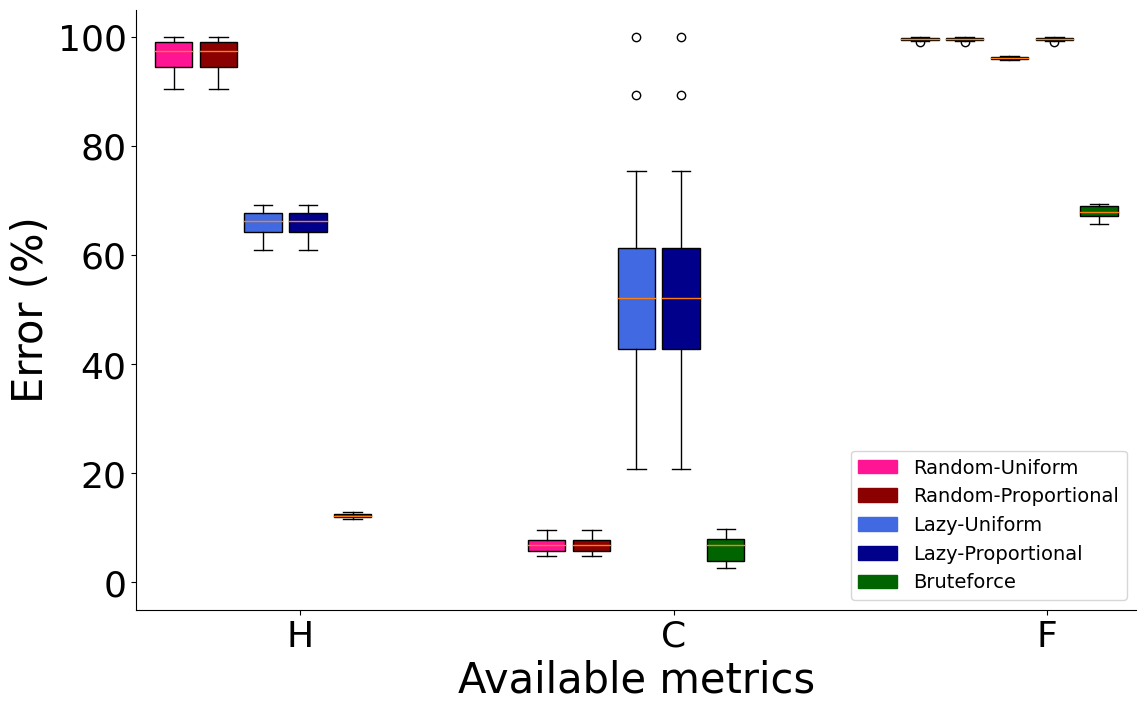

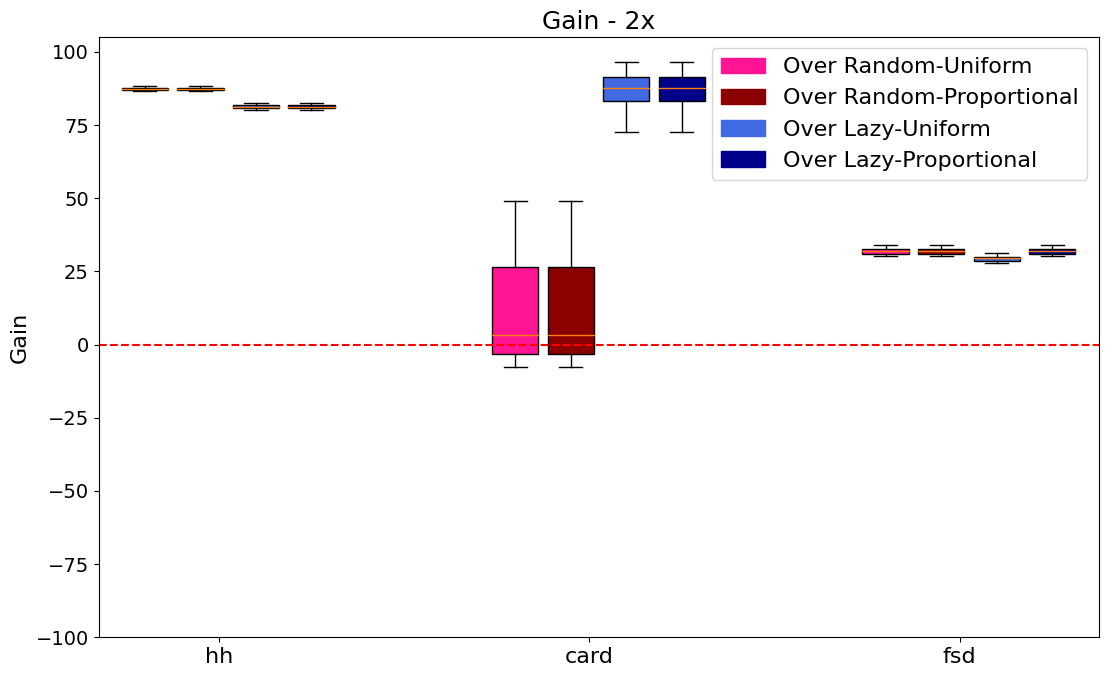

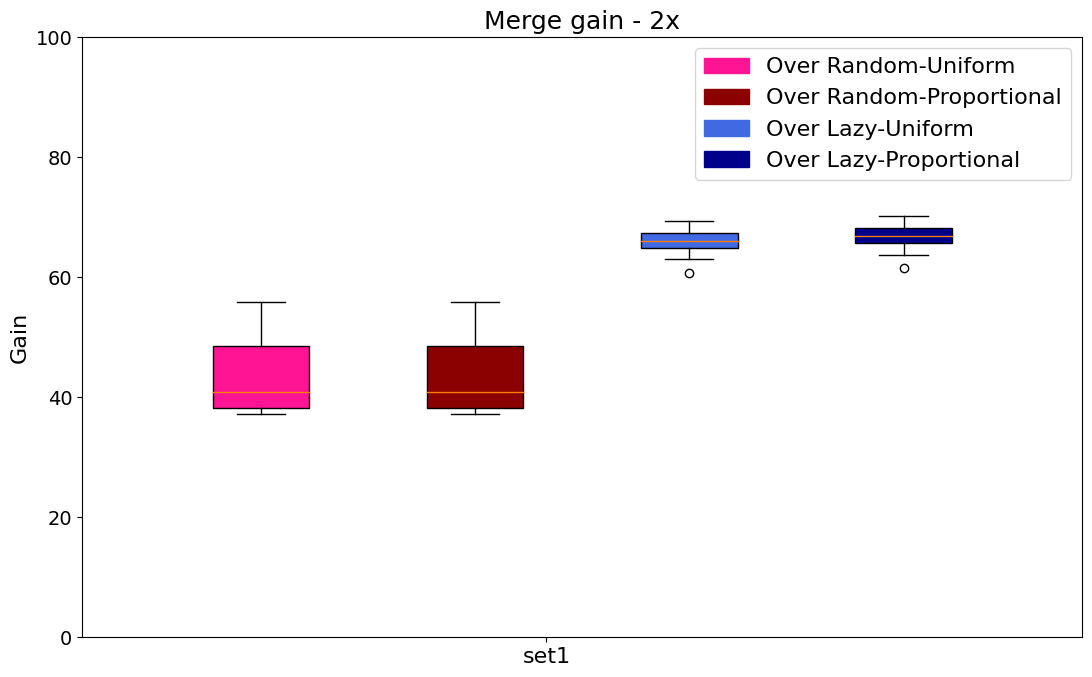

Num of run: 5
max_list: {'hh': 3686.174000679658, 'card': 20.328281578961835, 'fsd': 1.9557585729800906}


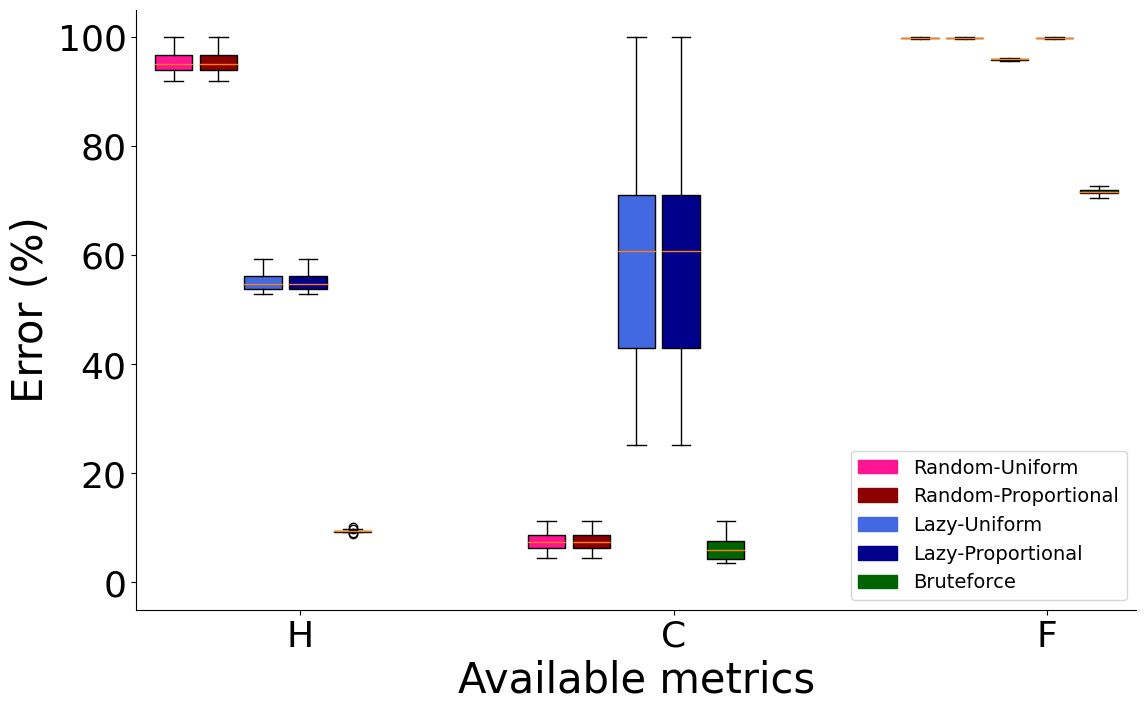

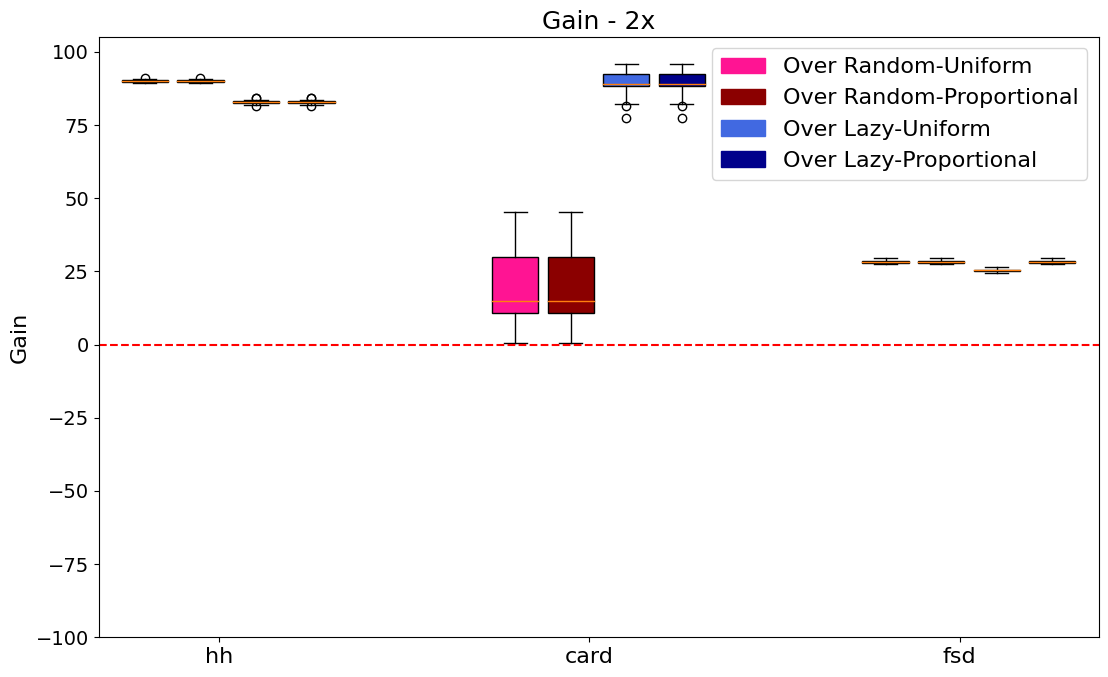

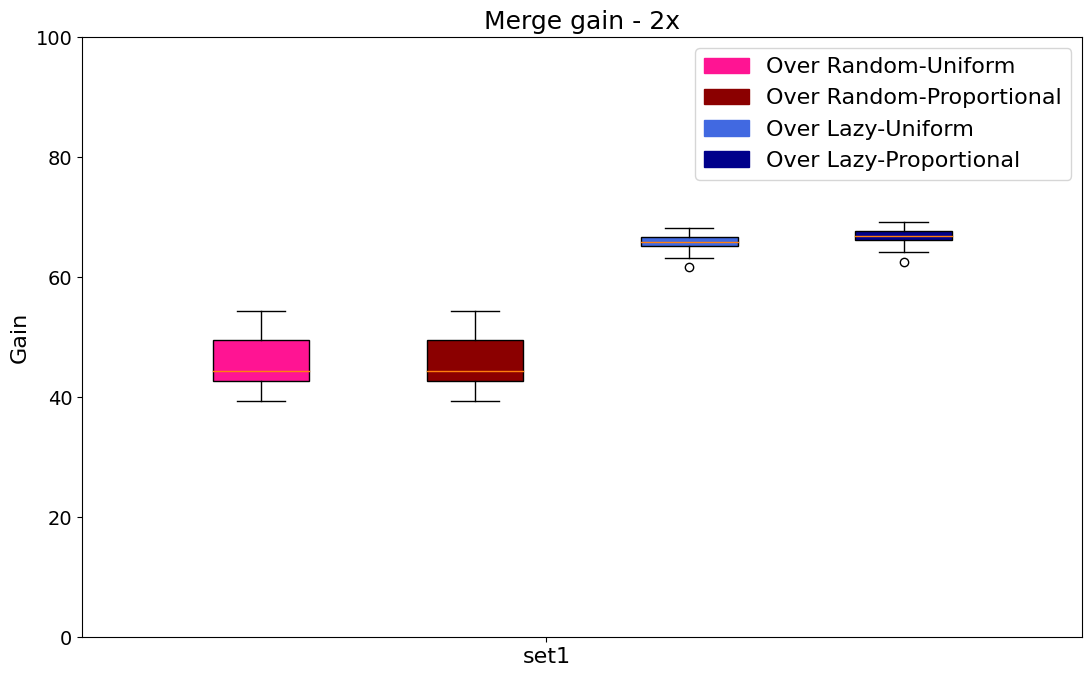

Num of run: 5
max_list: {'hh': 6937.84273381295, 'card': 21.96181046676096, 'fsd': 1.985896949754991}


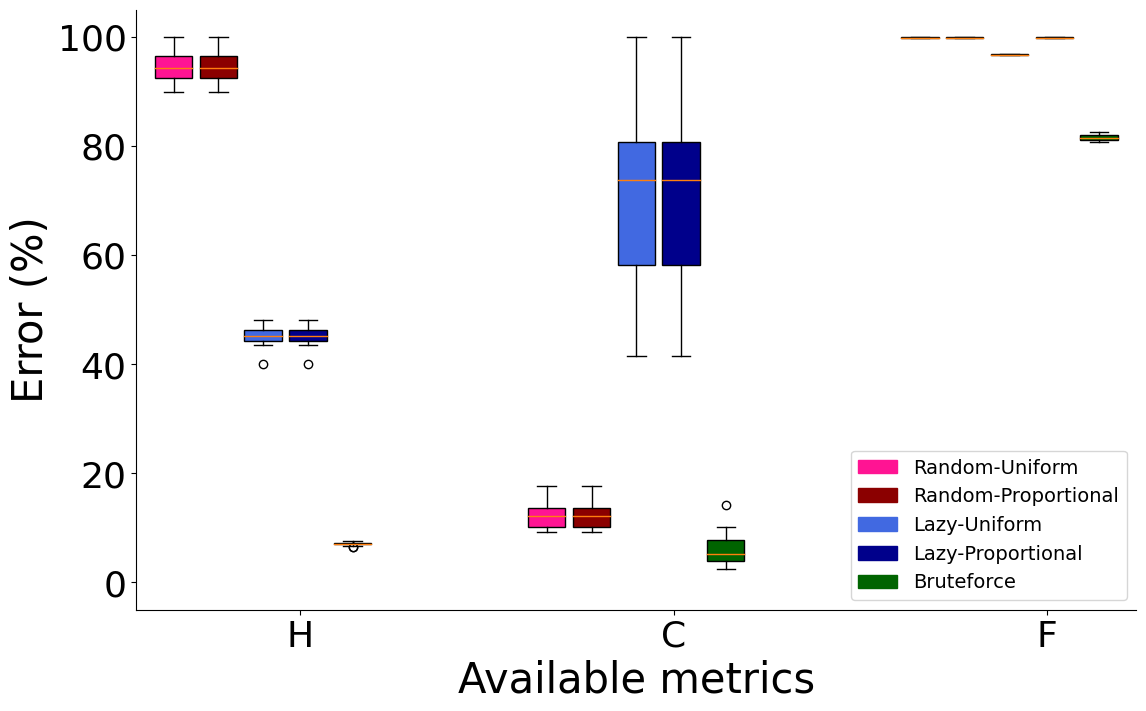

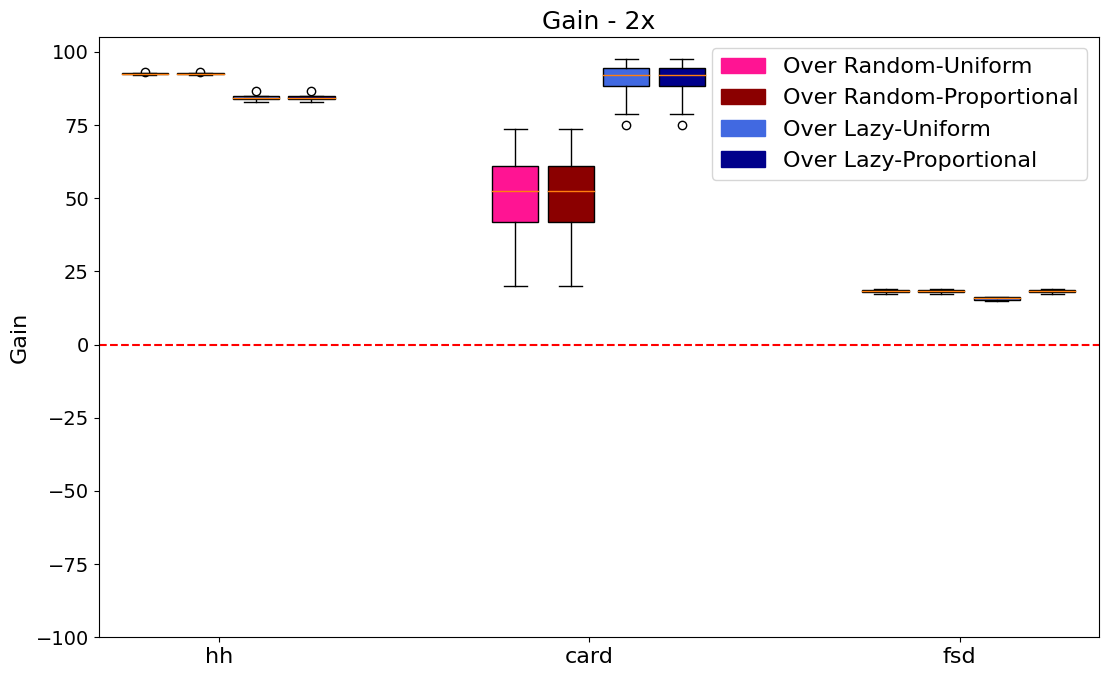

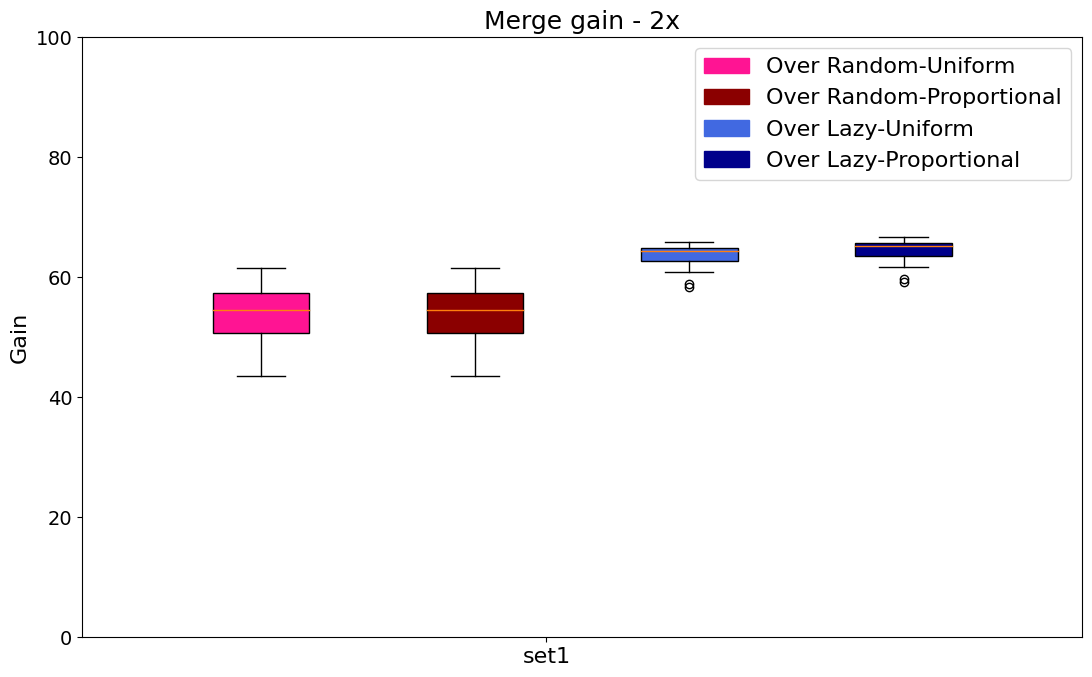

Num of run: 5
max_list: {'hh': 13047.318865248226, 'card': 28.28263372419777, 'fsd': 1.9996364029043279}


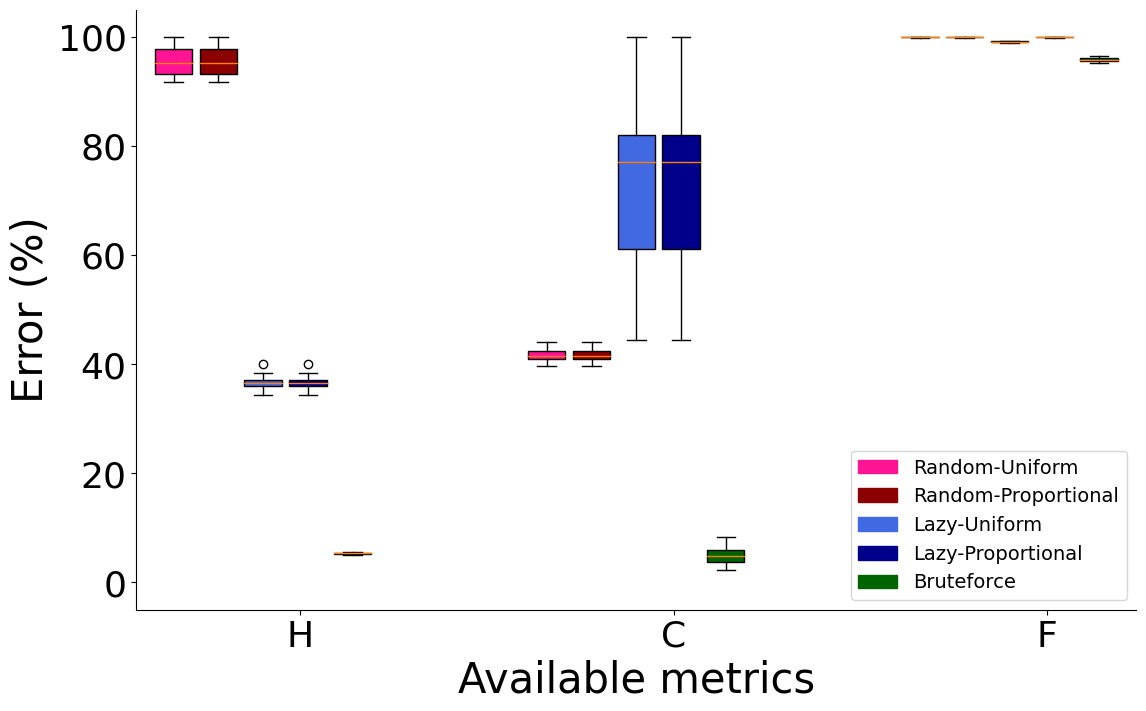

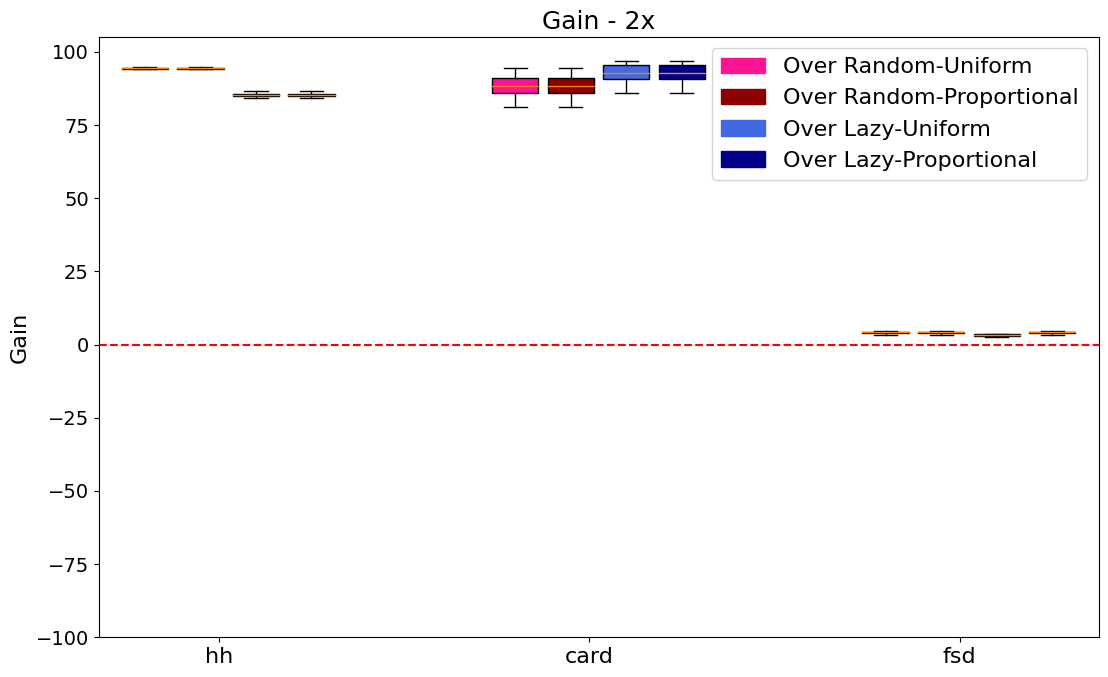

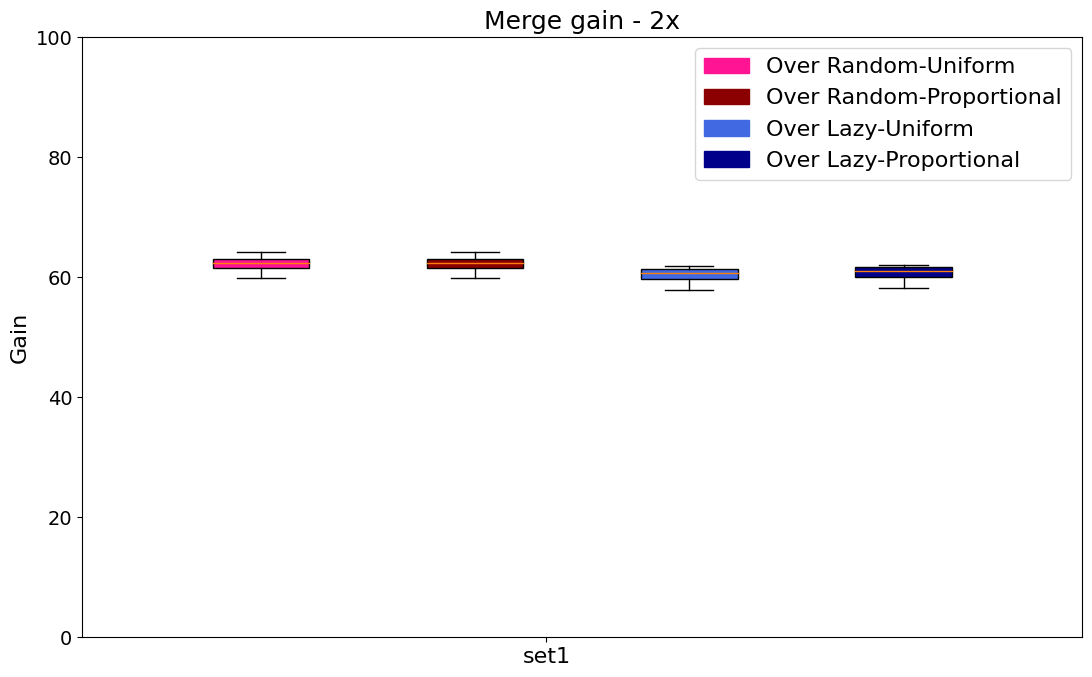

Num of run: 5
max_list: {'hh': 499.5793468965386, 'card': 14.258776551494648, 'fsd': 1.87239050067283}


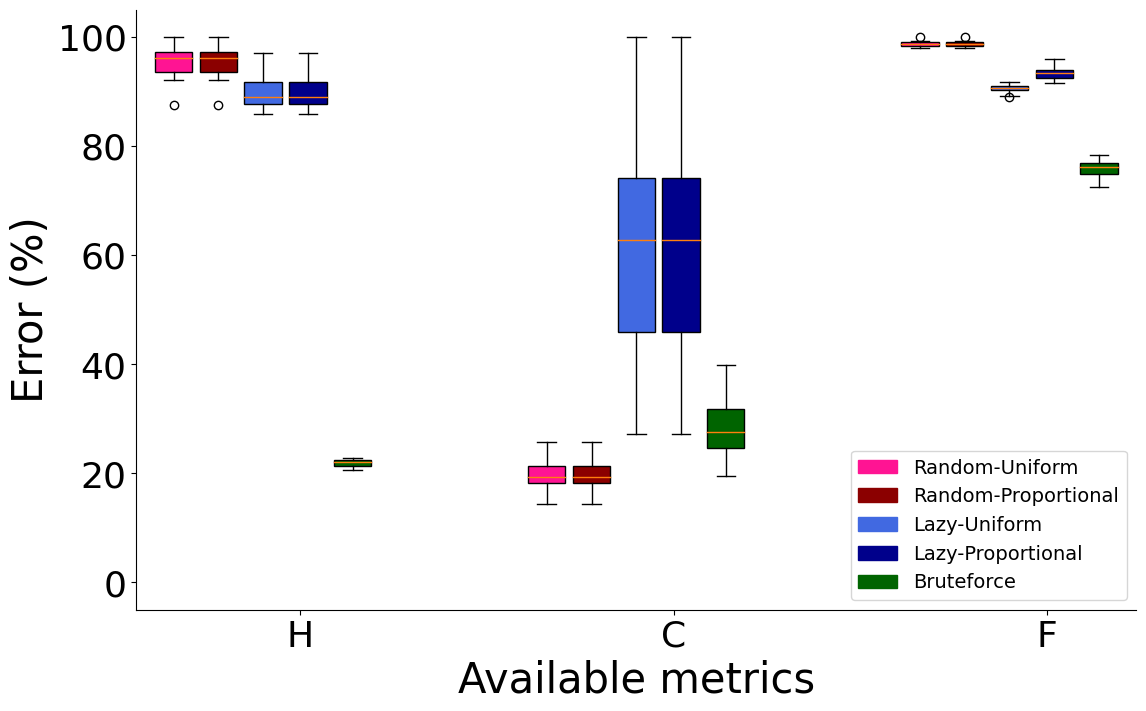

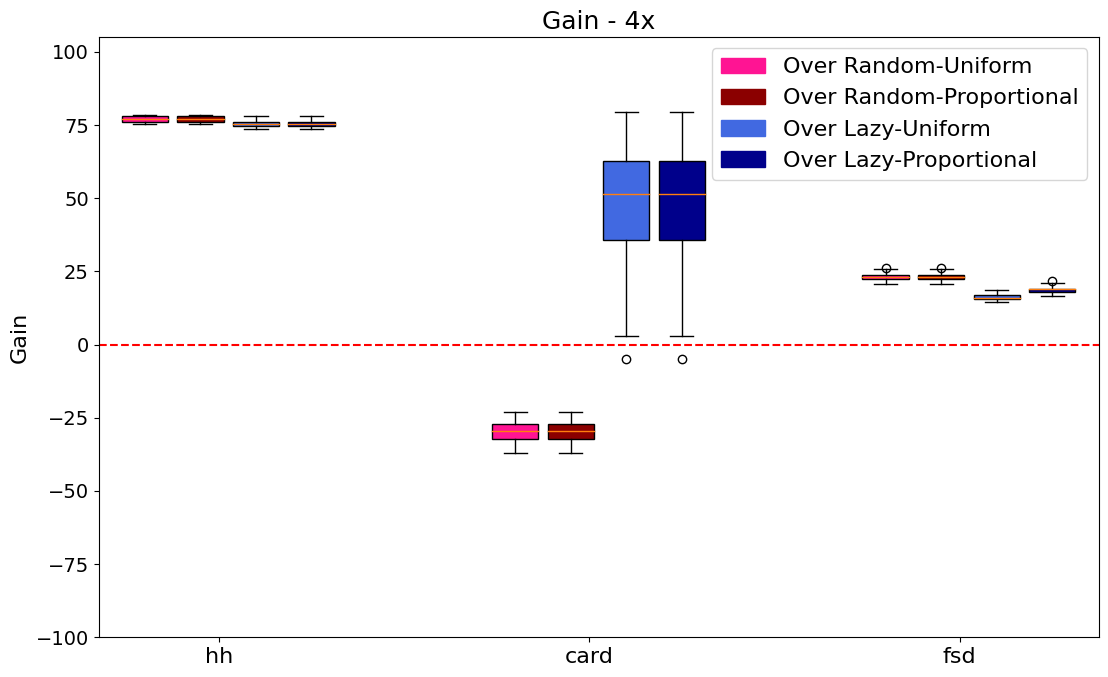

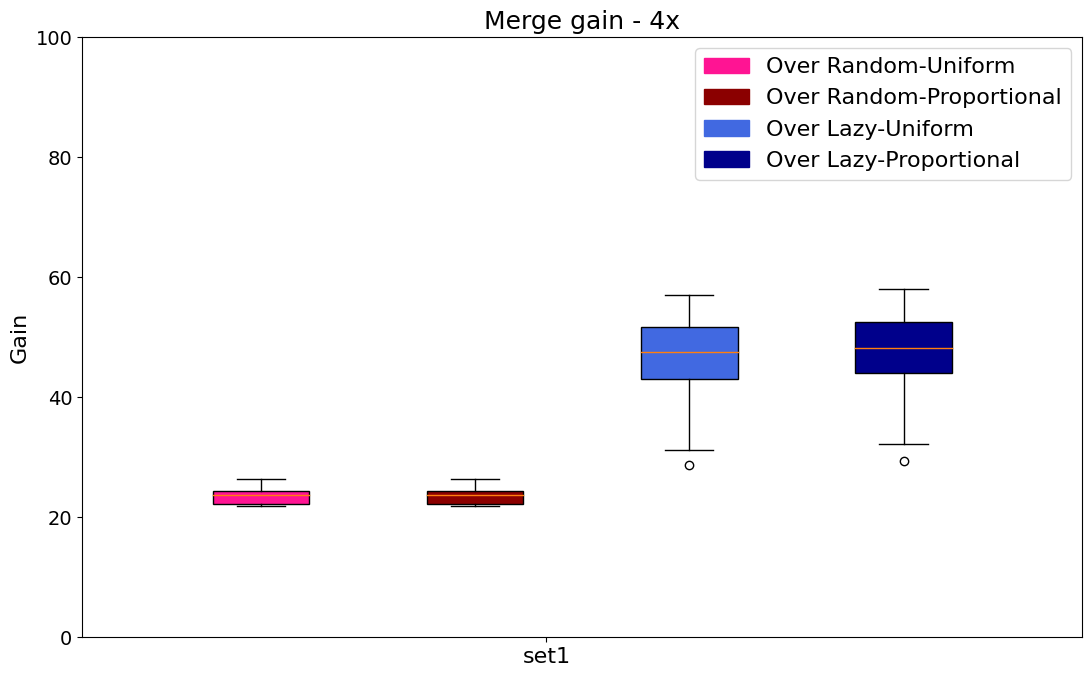

Num of run: 5
max_list: {'hh': 1984.0171264277712, 'card': 18.197732376622664, 'fsd': 1.9249998399145967}


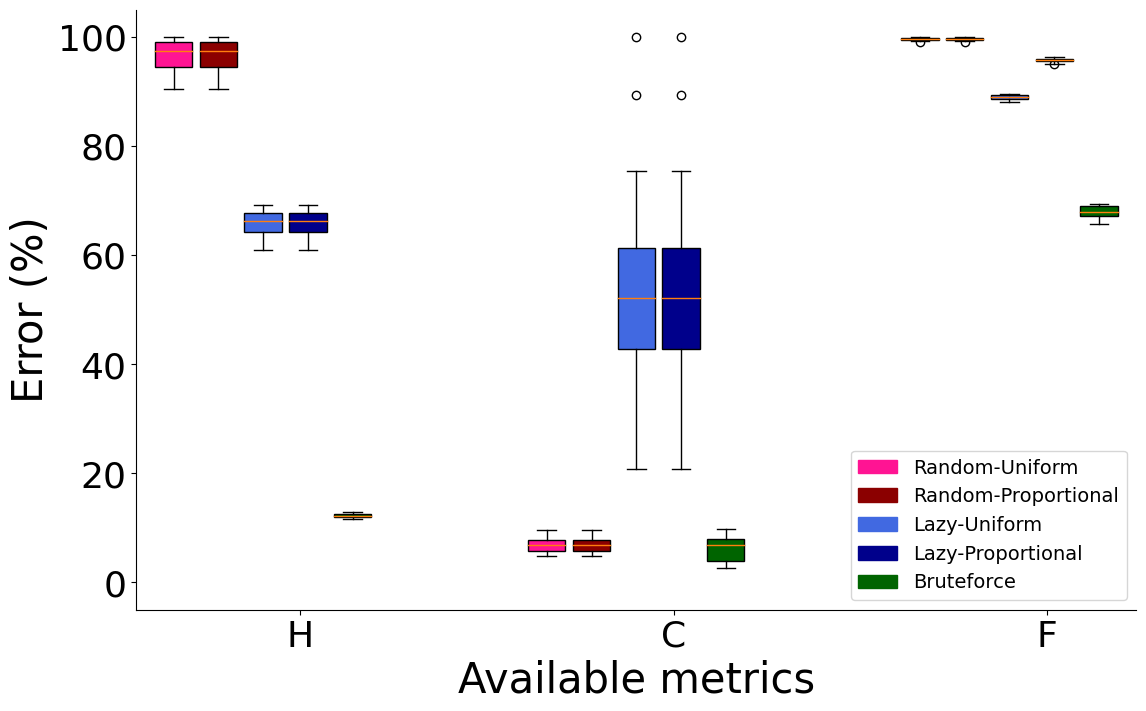

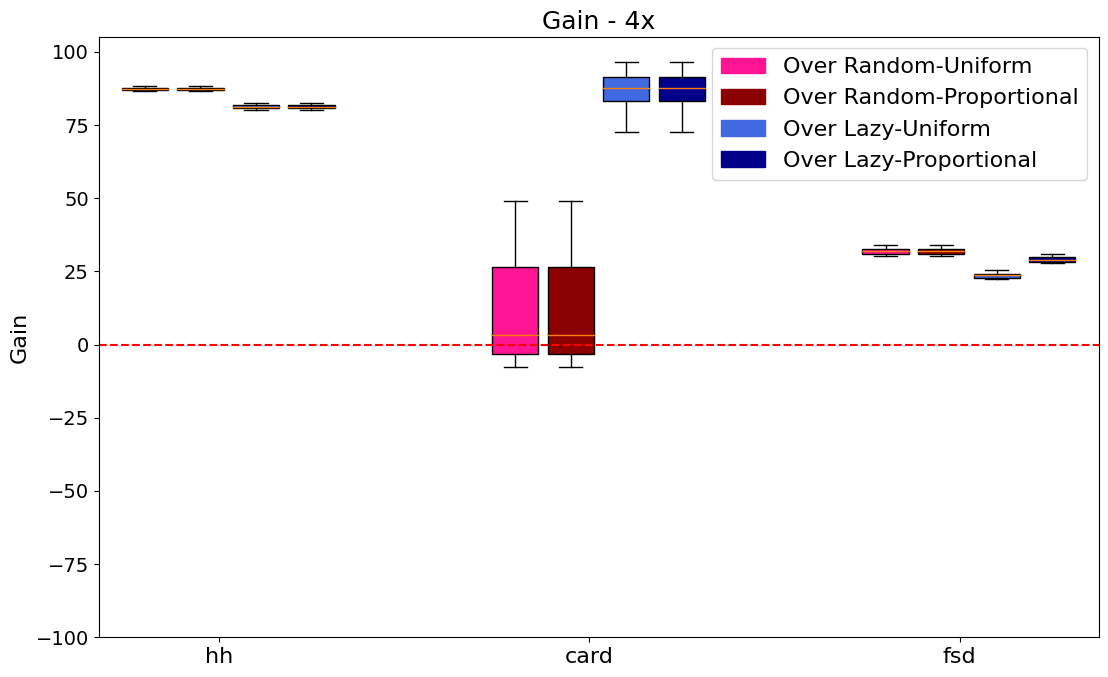

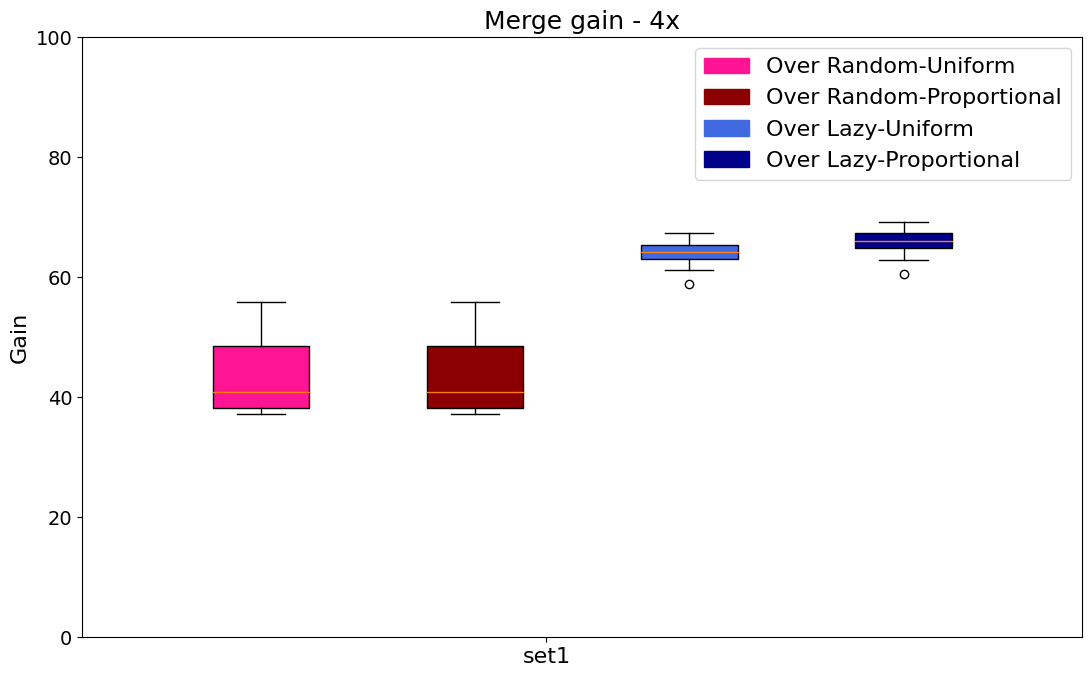

Num of run: 5
max_list: {'hh': 3686.174000679658, 'card': 20.328281578961835, 'fsd': 1.9557585729800906}


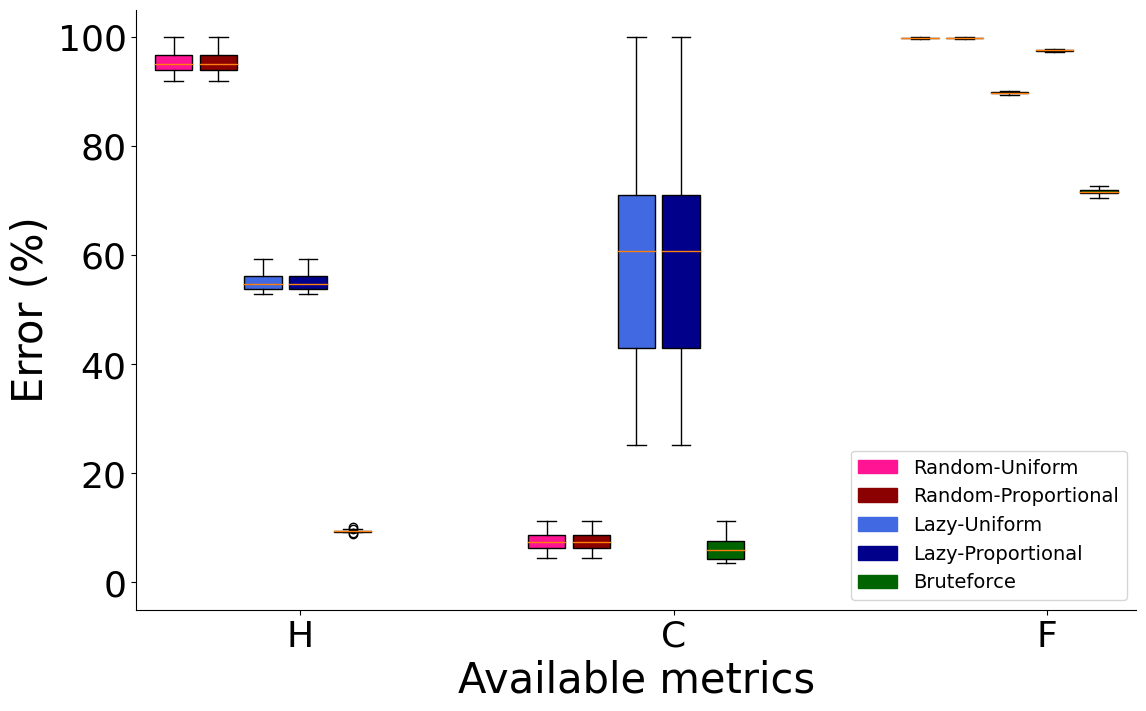

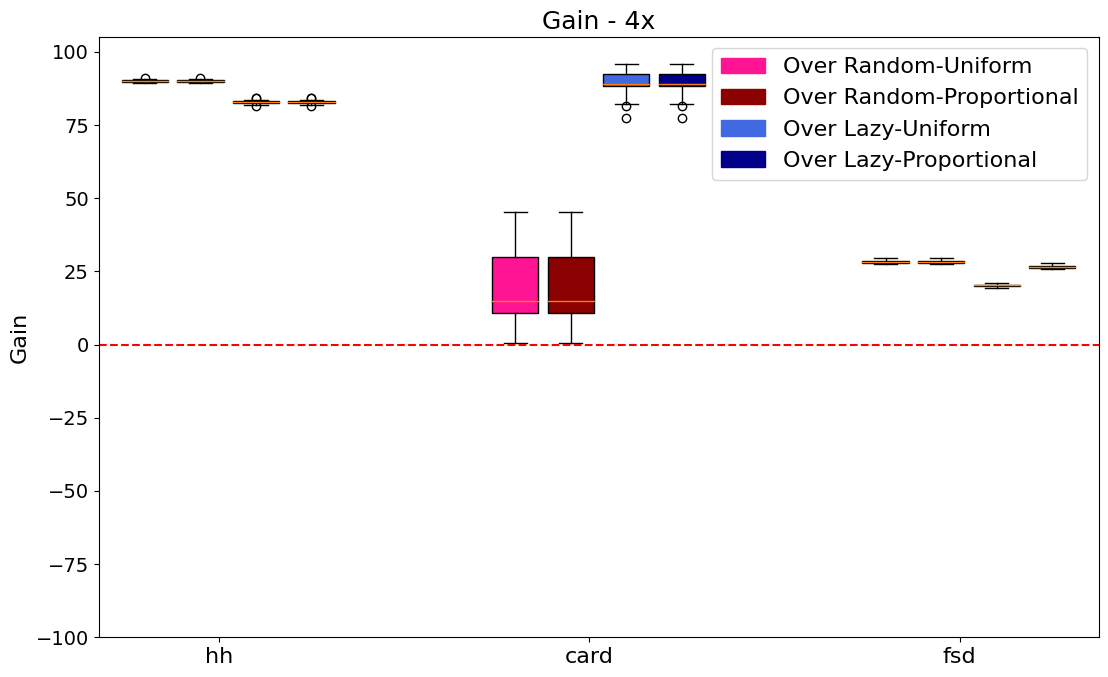

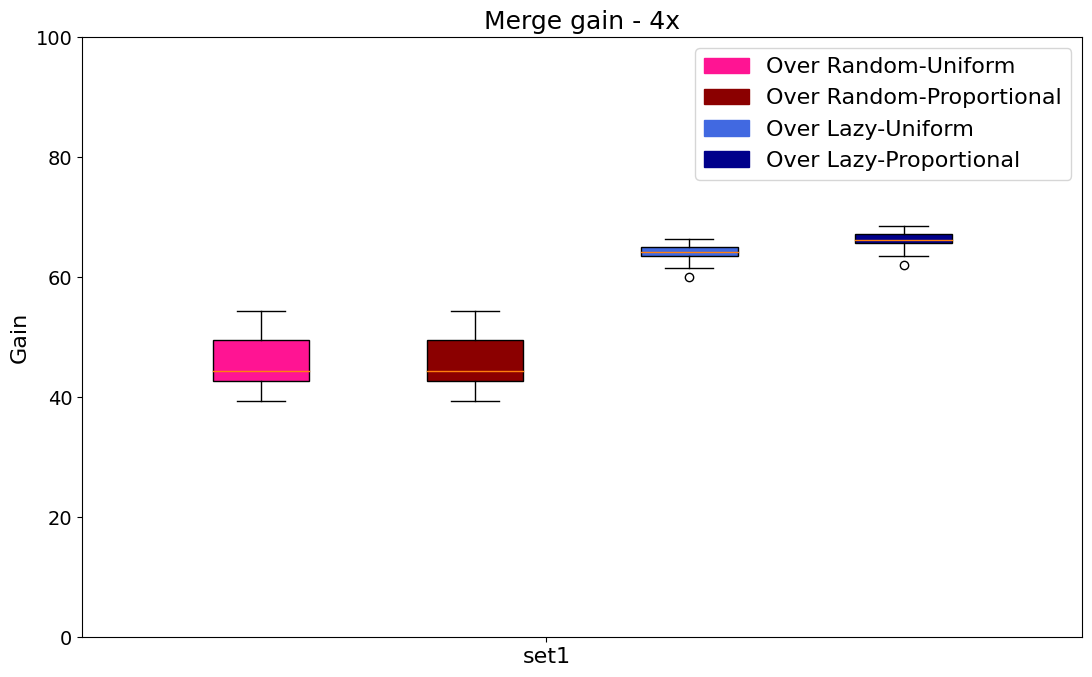

Num of run: 5
max_list: {'hh': 6937.84273381295, 'card': 21.96181046676096, 'fsd': 1.9858969497549908}


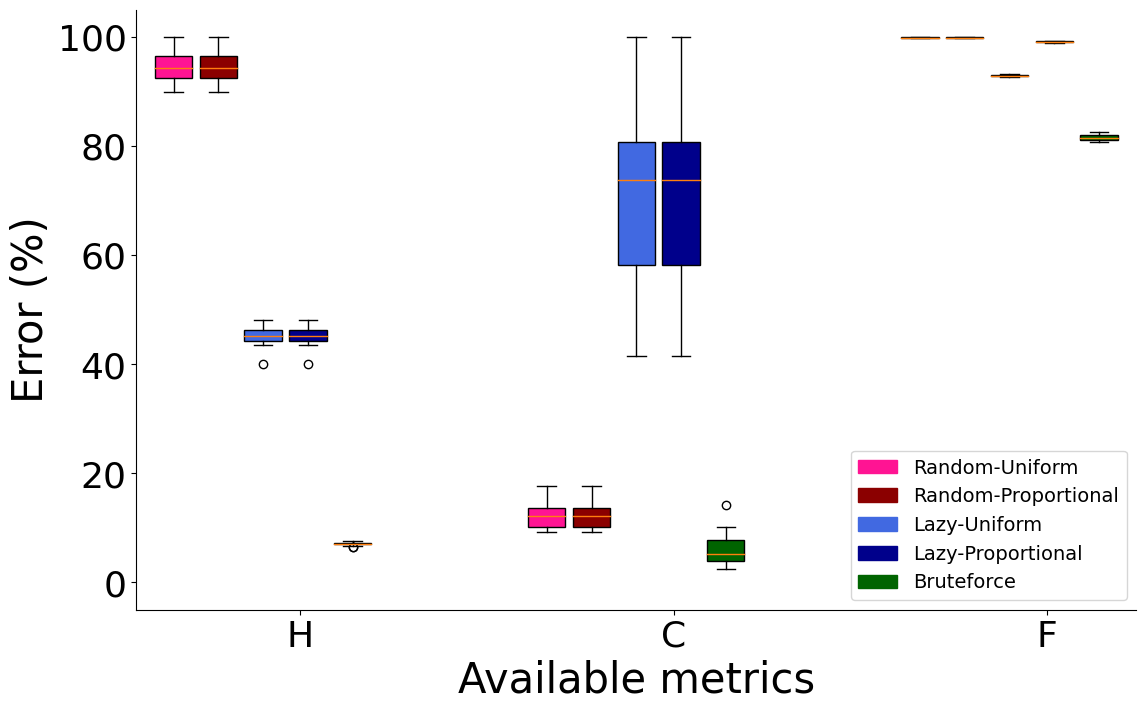

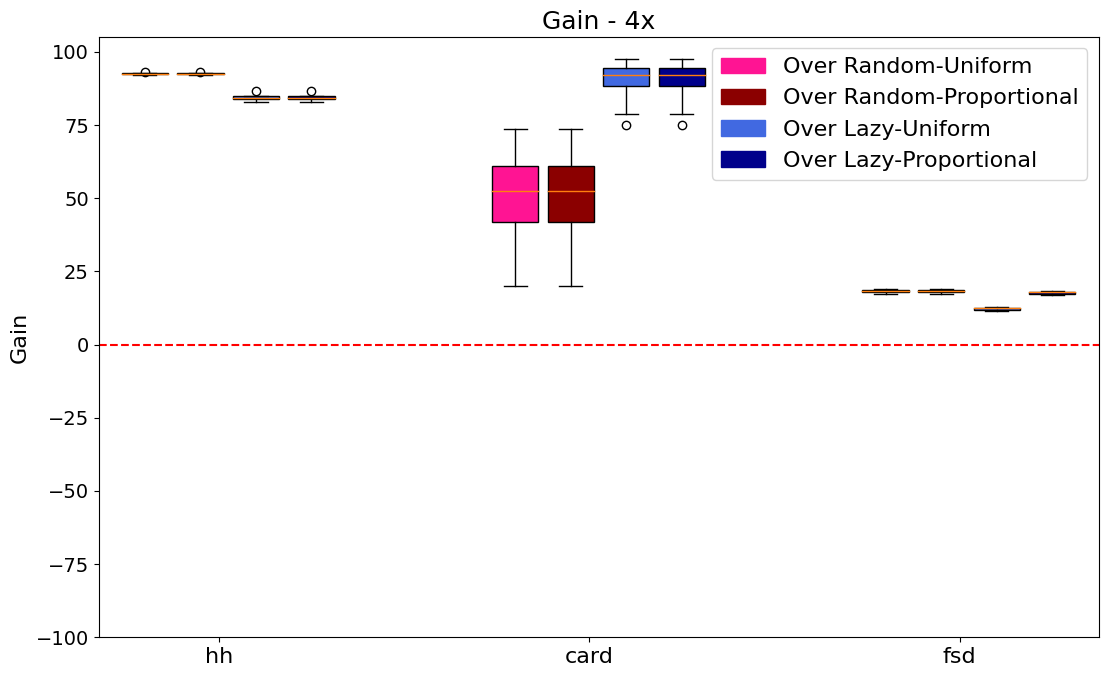

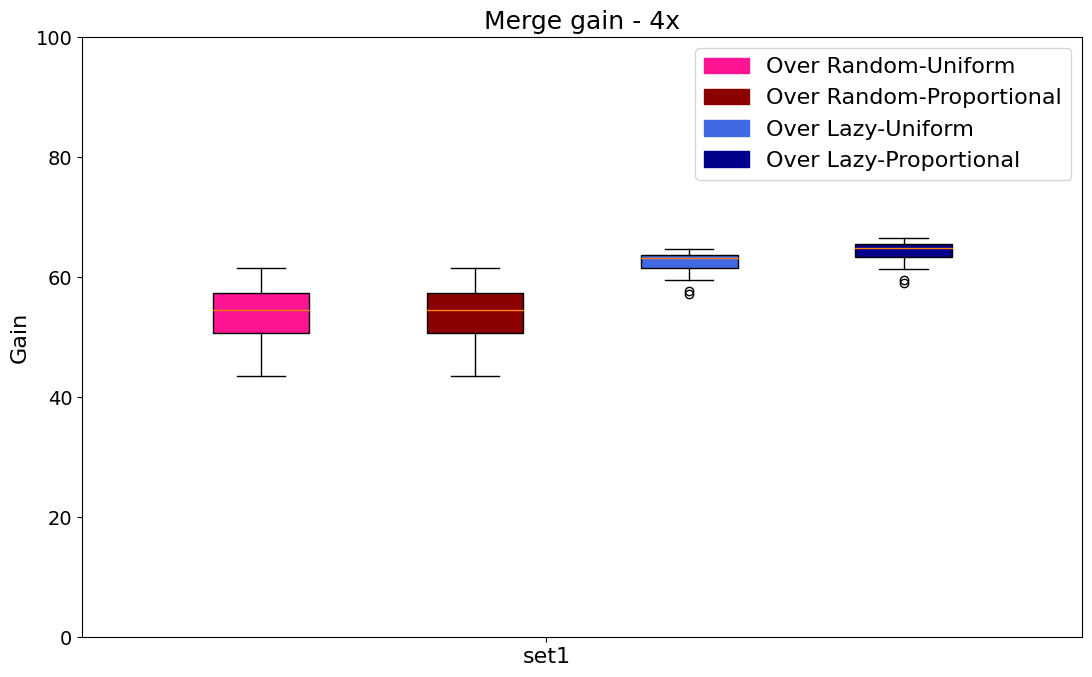

Num of run: 5
max_list: {'hh': 13047.318865248226, 'card': 28.28263372419777, 'fsd': 1.9996364029043279}


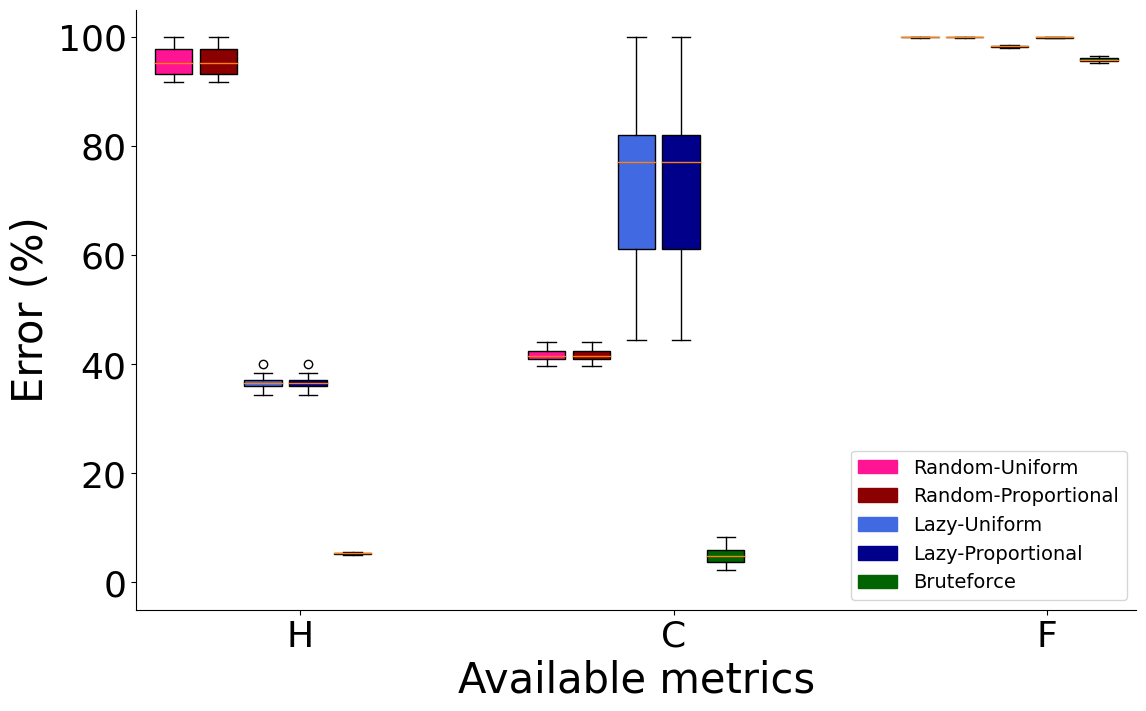

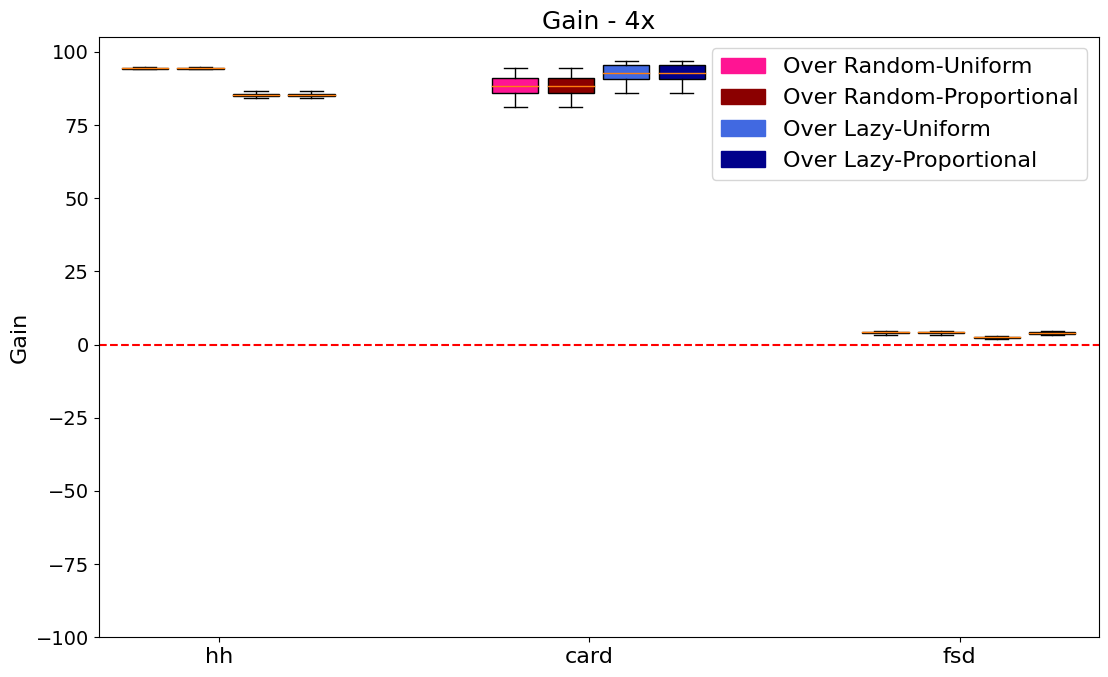

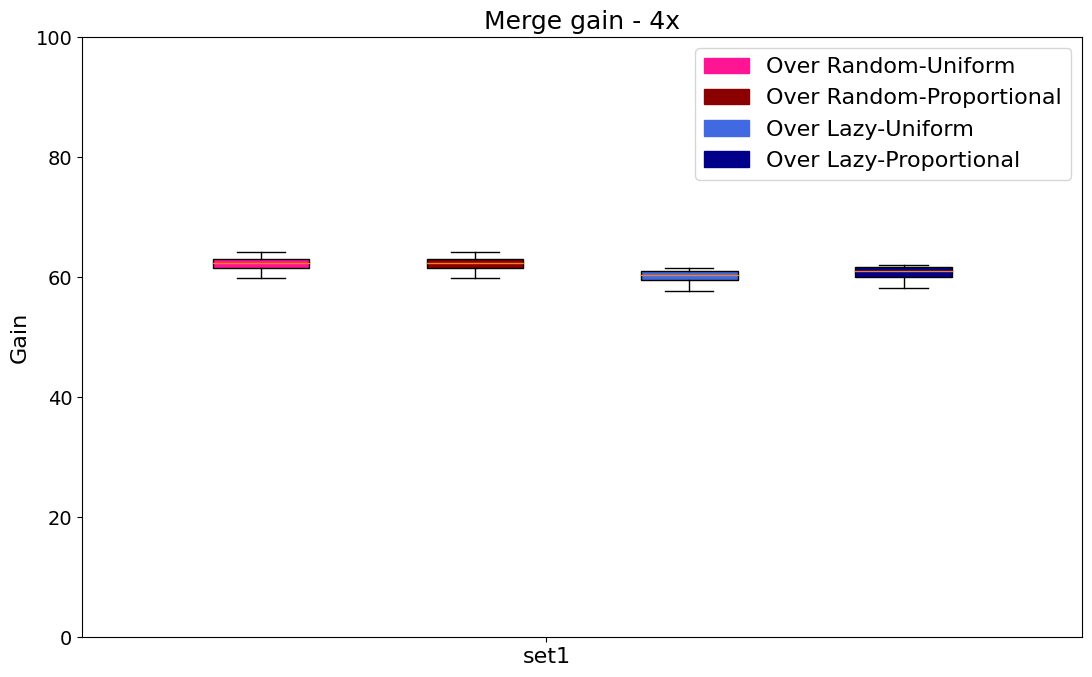

In [14]:
## testing datasets
datasets_list = [datasets_1, datasets_2, datasets_3, datasets_4, datasets_5]

## run testing datasets
for datasets in datasets_list:
    ## run testing datasets on a training set
    loop_unit_1(datasets)

for datasets in datasets_list:
    ## run testing datasets on a training set
    loop_unit_2(datasets)

for datasets in datasets_list:
    ## run testing datasets on a training set
    loop_unit_3(datasets)

for datasets in datasets_list:
    ## run testing datasets on a training set
    loop_unit_4(datasets)

for datasets in datasets_list:
    ## run testing datasets on a training set
    loop_unit_5(datasets)

### build heatmap

In [15]:
## sequence of `global_merge_gain_all_mem`

# 0. strawman 1 + caida train + caida test
# 1. strawman 2 + caida train + caida test
# 2. strawman 3 + caida train + caida test
# 3. strawman 4 + caida train + caida test

# 4. strawman 1 + caida train + uniform test
# 5. strawman 2 + caida train + uniform test
# 6. strawman 3 + caida train + uniform test
# 7. strawman 4 + caida train + uniform test

# 8. strawman 1 + caida train + zipf test
# 9. strawman 2 + caida train + zipf test
# 10. strawman 3 + caida train + zipf test
# 11. strawman 4 + caida train + zipf test

# 12. strawman 1 + uniform train + caida test
# ...

[[62.14306228 55.51530949 44.10615009 15.66976029  6.84146308]
 [62.14306228 55.51530949 44.10615009 15.66976029  6.84146308]
 [23.54965818 43.43070559 46.02123851 53.71986927 62.24563672]
 [23.54965818 43.43070559 46.02123851 53.71986927 62.24563672]
 [23.54965818 43.43070559 46.02123851 53.71986927 62.24563672]]


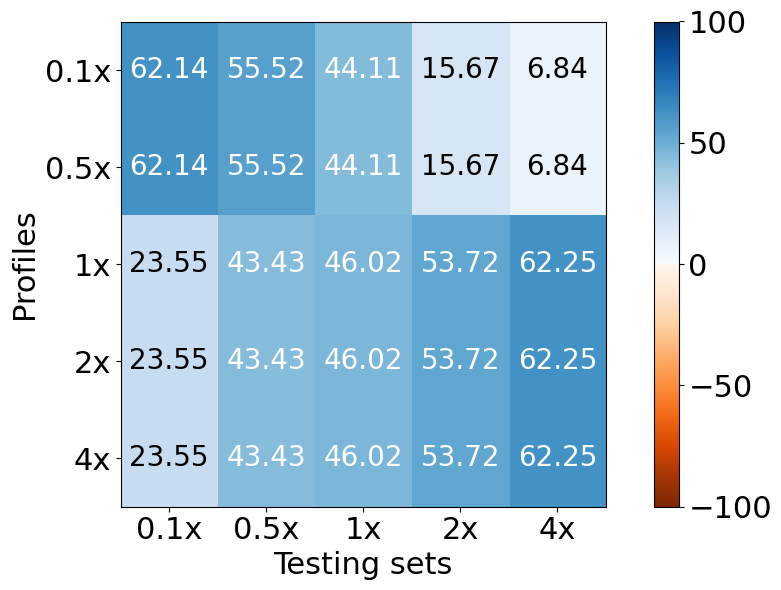

In [16]:
## iterate over all strawmen
for offset_strawman in range(num_of_strawmen):
    # 3x3's 2d array of mean value
    error_reductions = []
    ll = []
    ## iterate over 3x3
    # sequence: 
    # ---------------
    #   1  | 2  | 3
    # ---------------
    #   4  | 5  | 6
    # ---------------
    #   7  | 8  | 9
    # ---------------
    # idx: 0, 4, 8, 12, 16, 20, 24, 28, 32
    for i in range(num_of_datasets**2):
        idx = i * num_of_strawmen + offset_strawman
        # print(idx)
        
        ll.append(np.mean(global_merge_gain_all_mem[idx]))
        if len(ll) == num_of_datasets:
            error_reductions.append(ll)
            ll = []
    error_reductions = np.array(error_reductions)
    
    title = f"Ensemble - Error reduction - {strawman_labels[offset_strawman]}"
    print(error_reductions)
    
    plot_heatmap(error_reductions, ytick_labels, xtick_labels, title, isSaveFig, output_dir)
    break

### build boxplot

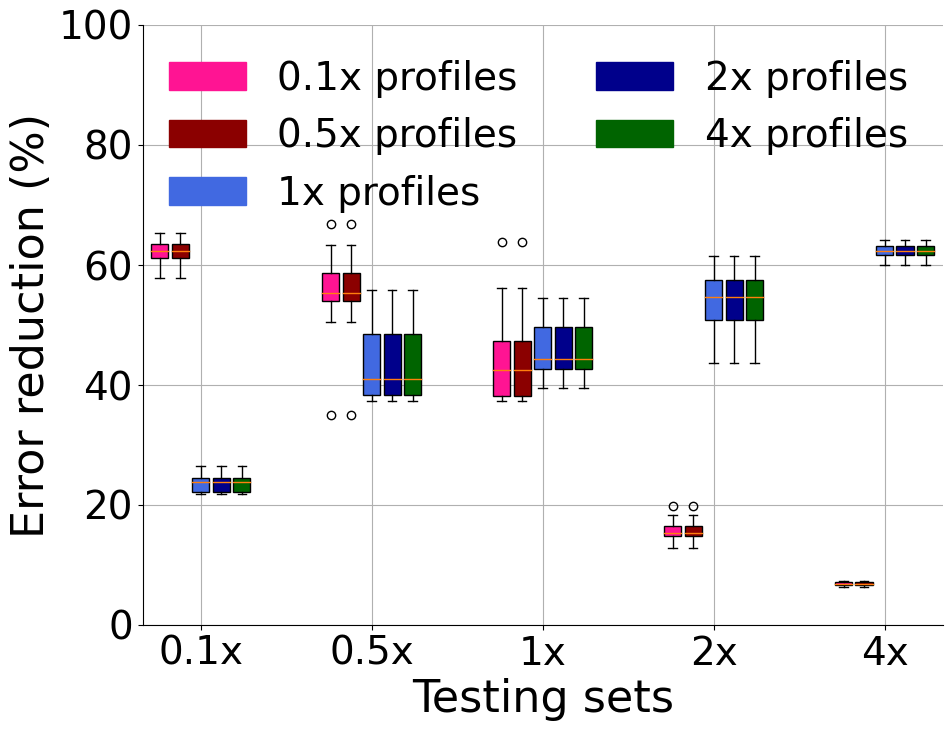

In [17]:
## iterate over all strawmen
for offset_strawman in range(num_of_strawmen):
    # 9x1's 1d array of list of values
    error_reductions = []
    ## iterate over 9 box
    # sequence: 
    # -> caida test (x3 training) 
    # -> unifrom test (x3 training)
    # -> zipf test (x3 training)
    
    # ---------------
    #   1  | 4  | 7
    # ---------------
    #   2  | 5  | 8
    # ---------------
    #   3  | 6  | 9
    # ---------------
    
    # idx: 0, 12, 24, 4, 16, 28, 8, 20, 32
    
    for i in range(num_of_datasets):
        for j in range(num_of_datasets):
            idx = (i + j * num_of_datasets) * num_of_strawmen + offset_strawman
            # print(idx)
            
            error_reductions.append(global_merge_gain_all_mem[idx])

    # error_reductions = np.array(error_reductions)
    
    title = f"Ensemble - Error reduction - {strawman_labels[offset_strawman]}"
    # print(error_reductions)
    
    boxplot_impact_distribution(error_reductions, xtick_labels, title, isSaveFig)
    break